# Project 3: Image Analysis - First Year Project 2021 
## Detecting melanoma from images  
---
### Group 8: Ida Maria Zachariassen, Magnus Sverdrup, Rasmus Bondo Hansen, Ruben Oliver Jonsman and Sabrina Fonseca Pereira

This notebook contains all the code developed in the Project 3 - Detecting Melanoma in medical imaging

Contact/Group: 
- Ida Maria Zachariassen(idza@itu.dk)
- Magnus Sverdrup(magsv@itu.dk)
- Rasmus Bondo Hansen(rabh@itu.dk)
- Ruben Jonsman(rubj@itu.dk)
- Sabrina Fonseca Pereira(sabf@itu.dk)

### Introduction

The project presented in this report was developed with the purpose of researching and analysing the visual identification and classification of potential melanoma cancerous lesions through imaging. This project also aims to investigate how a model based on the characteristics of melanoma lesions performs when classifying keratosis lesions. This was done to gain insight and knowledge about extracting features from medical imaging and using these features in simple classifiers. Lastly the report is an evaluation on whether visual classification of skin lesions is a reliable source for cancer detection. Based on our analysis of various models for classifying features of skin lesions, the following research question was formulated: "How do models trained on melanoma lesions perform when classifying seborrheic keratosis lesions?"

# Required Libraries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import skimage
import seaborn as sns
from PIL import Image
from skimage import io, color
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import confusion_matrix

%run -i ../scripts/fyp2021p3_group08_functions.py

In [2]:
# seting seaborn theme
sns.set_theme()

## Consistent variables
### Paths to the data

In [3]:
PATH = {}

#Paths to the example data
PATH["data_example"] = "../data/example/example_ground_truth.csv"
PATH["data_example_image"] = "../data/example/example_image/{}.jpg"
PATH["data_example_segmentation"] = "../data/example/example_segmentation/{}_segmentation.png"

#Paths to the final csv files
PATH["balanced_data_melanoma"] = "../data/processed/final_balanced.csv"
PATH["data_melanoma"] = "../data/processed/final_unbalanced.csv"

#Path to the task 3 csv file
PATH["keratosis"] = "../data/processed/keratosis.csv"

# Path to the 2017 data set
PATH["data_2017"] = "../data/2017/ISIC-2017_Training_Part3_GroundTruth.csv"
PATH["data_2017_image"] = "../data/2017/ISIC-2017_Training_Data/{}.jpg"
PATH["data_2017_segmentation"] = "../data/2017/ISIC-2017_Training_Part1_GroundTruth/{}_segmentation.png"

In [4]:
print(PATH["data_example_image"].format("ISIC_0012151"))
print(PATH["data_example_segmentation"].format("ISIC_0012151"))
print(PATH["data_example"])

../data/example/example_image/ISIC_0012151.jpg
../data/example/example_segmentation/ISIC_0012151_segmentation.png
../data/example/example_ground_truth.csv


### Pandas data frames

In [5]:
#Example dataframe
data_example = pd.read_csv(PATH["data_example"])
data_example

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0
...,...,...,...
145,ISIC_0015443,0.0,0.0
146,ISIC_0015445,0.0,0.0
147,ISIC_0015483,0.0,0.0
148,ISIC_0015496,0.0,0.0


In [6]:
# Final dataframe with the precalculated features
non_balanced_df = pd.read_csv(PATH["data_melanoma"])
balanced = pd.read_csv(PATH["balanced_data_melanoma"])

df = non_balanced_df
df

,image_id,melanoma,seborrheic_keratosis,radius_sd,radius_mean,area,perimeter,compactness,diagnosis_sum,diagnosis,...,b_std,average_std,r_range,g_range,b_range,r_pct,g_pct,b_pct,r_low,b_high
0,ISIC_0000000,0.0,0.0,142.796002,373.374403,364956.0,2258.0,1.111725,0.0,not melanoma,...,0.620079,0.660033,0.567568,0.592233,0.710145,0.3399,0.3183,0.3418,0.0932,0.2144
1,ISIC_0000001,0.0,0.0,88.198414,229.017981,53432.0,914.0,1.244174,0.0,not melanoma,...,0.230567,0.367522,0.522523,0.378641,0.396135,0.4428,0.3104,0.2469,0.1328,0.0000
2,ISIC_0000002,1.0,0.0,110.927367,304.913068,237402.0,2071.0,1.437692,1.0,melanoma,...,0.564853,0.480467,0.391892,0.470874,0.666667,0.3697,0.3071,0.3233,0.0005,0.2243
3,ISIC_0000003,0.0,0.0,166.513656,346.623696,260712.0,1848.0,1.042397,0.0,not melanoma,...,0.427639,0.550965,0.648649,0.606796,0.545894,0.4319,0.3204,0.2477,0.0024,0.0393
4,ISIC_0000004,1.0,0.0,79.699652,305.763837,269484.0,1746.0,0.900214,1.0,melanoma,...,0.523281,0.592497,0.905405,0.893204,0.859903,0.4066,0.2685,0.3249,0.0081,0.4463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,ISIC_0015190,1.0,0.0,1093.195716,2377.036328,12575987.0,18268.0,2.111690,1.0,melanoma,...,0.436331,0.635530,0.815315,0.728155,0.671498,0.5159,0.2778,0.2063,0.0013,0.0075
1742,ISIC_0015200,1.0,0.0,1133.852851,2924.837093,20680044.0,21573.0,1.790852,1.0,melanoma,...,0.844189,0.985986,0.990991,1.000000,1.000000,0.3863,0.3225,0.2911,0.0294,0.3748
1743,ISIC_0015204,1.0,0.0,638.148297,2216.116253,13977416.0,17821.0,1.808121,1.0,melanoma,...,0.912955,1.000000,0.981982,1.000000,1.000000,0.3905,0.3102,0.2994,0.0168,0.3873
1744,ISIC_0015219,1.0,0.0,1007.059034,2076.991674,8019976.0,13546.0,1.820703,1.0,melanoma,...,0.484206,0.638342,0.900901,0.995146,1.000000,0.5013,0.2439,0.2548,0.0132,0.0368


In [7]:
# Keratosis dataframe for task 3
keratosis = pd.read_csv(PATH["keratosis"])

## For reproducibility 
If the reader wants to reproduce our features, one has to set CALCULATE_FEATURE to be True and has to have the ISIC 2017 challenge dataset downloaded and placed into the data folder.

The specifc data we have extracted from the ISIC 2017 dataset can be downloaded from the following link: https://www.dropbox.com/sh/yuxz09swxntpg5t/AAD5qq-P32dUOQpqeCXg5uoTa?dl=0

- Click the download button in the top-right corner
- Place the 4 files in the folder `data/2017`

In [8]:
CALCULATE_FEATURE = False

In [9]:
if CALCULATE_FEATURE:
    dataframe = pd.read_csv(PATH["data_2017"])

As the reader goes through our notebook, the pandas dataframe called "dataframe" will gradually be filled with our features. N.B: the computation time for most of our features are very long. The results are already calculated and can be seen in the dataframe called "non_balanced_df".

## Functions

### Plotting the testing of parameters in ML classifiers

In [10]:
def plot_test_ML(validation_acc, validation_auc, training_acc, training_auc, xlabel):
    fig, ax = plt.subplots(2,2,figsize=(13,4))
    ax[0,0].set_title("validation accuracy")
    ax[0,0].plot(range(1,len(validation_acc)+1), validation_acc);
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel("accuracy");


    ax[0,1].set_title("validation roc_auc accuracy")
    ax[0,1].plot(range(1,len(validation_acc)+1), validation_auc)
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel("accuracy");

    ax[1,0].set_title("training accuracy")
    ax[1,0].plot(range(1,len(validation_acc)+1), training_acc);
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel("accuracy");


    ax[1,1].set_title("training roc_auc accuracy")
    ax[1,1].plot(range(1,len(validation_acc)+1), training_auc)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel("accuracy");
    fig.tight_layout()

### Calculation of the symmetric feature

In [11]:
def crop_to_lesion(picture, segment):
    """
    "Zooms" in on the lesion, meaning it cuts away everything else
    
    Takes a picture and it's corresponding mask/segment
    Returns the picture and the segment, cropped to only the lesion 
    """
    
    height = segment.shape[0]
    width = segment.shape[1]
       
    img_df = pd.DataFrame(segment)    
    
    x_1 = x_2 = 0
    y_1 = y_ = 0
    
    # Iterating over all the columns finding the first column that has a white pixel
    for i in range(width):
        if list(img_df[i]).count(1.0) > 0:
            x_1 = i
            break
        else:
            continue
            
    # Iterating over all the columns backwards finding the first column that has a white pixel
    for i in range(width):
        if list(img_df[(width-1) - i]).count(1.0) > 0:
            x_2 = ((width-1) - i)
            break
        else:
            continue   
    
    
    # Iterating over all the rows finding the first row that has a white pixel
    for i in range(height):
        if list(img_df.loc[i]).count(1.0) > 0:
            y_1 = i
            break
        else:
            continue   
    
    # Iterating over all the rows backwards finding the first row that has a white pixel
    for i in range(height):
        if list(img_df.loc[(height-1) - i]).count(1.0) > 0:
            y_2 = ((height-1) - i)
            break
        else:
            continue
    
    img_part = picture[y_1:y_2,x_1:x_2]
    segment_part = segment[y_1:y_2,x_1:x_2]
    
    return (img_part, segment_part)

In [12]:
def rescale_img(segment, scale):
    """
    Rescales an image so it has the width of the scale
    
    Takes a segment/mask
    Returns the segment/mask rescaled to have the width of the scale
    """
    
    width = segment.shape[1]
        
    cut_rescaled_segment = skimage.transform.rescale(segment, scale/width, anti_aliasing=False)
    
    return cut_rescaled_segment

In [13]:
def edge_points(segment):
    """
    Finds all the coordinates to the points which lie on the edge of the lesion. 
    This function creates an identical image to the segment only one pixel smaller. Then subtracts the segment 
    with the smaller segment and we are left with only the border. It then goes through all the white pixels left and maps it.
    
    Takes a segment
    Returns a list with the coordinates to all the edge points
    
    """
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(segment, struct_el)
    image_perimeter = segment - mask_eroded
    
    height = segment.shape[0]
    width = segment.shape[1]
    
    perimeter_df = pd.DataFrame(image_perimeter)
    
    coords = []
    
    for i in range(width):
        for val, j in zip(perimeter_df[i], range(len(perimeter_df[i]))):
            if val == 1.0:
                coords.append((i,j))
                
    return coords

In [14]:
def longest_diameter(segment):
    """
    Calculates the longest distance among all the edge points. Takes quadratic time since it has to calculate the distance
    from all the coordinates to all the coordinates.
    
    Takes a segment
    Returns the longest distance, and the two coordinates that makes the longest distance
    """
    edge_coords = edge_points(segment)
    dist = {}
    
    for coord, i in zip(range(len(edge_coords)),edge_coords):
        dist.update({coord:[]})
        for coord2,j in zip(range(len(edge_coords)),edge_coords):
            length = edge_coords[coord][1] - edge_coords[coord2][1]
            width = edge_coords[coord][0] - edge_coords[coord2][0]
            dist[coord].append(((round(((length**2+width**2)**0.5),2)),(i,j)))
            
    # creates a list of only the longest coordinate pair for every coordinate
    coordinates_max = [max(dist[key]) for key in dist]
    # Returns only the max of the list
    return max(coordinates_max)

In [15]:
def tilt_image(segment):
    """
    Rotates a segment so it's longest diameter is vertical
    Takes a long time if run with a normal picture that has not been rescaled.
    
    Takes a segment
    Returns the segment so it is vertical
    """
    length, coord = longest_diameter(segment)
    xy1 = coord[0]
    xy2 = coord[1]
    
    v1 = (xy2[0]-xy1[0], xy2[1]-xy1[1])
    v2 = (0,100)
    
    angel = 180-math.degrees(math.acos((v1[0]*v2[0]+v1[1]*v2[1])/(math.sqrt(v1[0]**2+v1[1]**2)*math.sqrt(v2[0]**2+v2[1]**2))))                       

    rot_im = skimage.transform.rotate(segment, 360-angel)
    return rot_im

In [16]:
def symmetric(seg, plot = False):
    """
    Calculates how "symmetric" a segment is. It flips the picture 180 degrees mirrors it and subtracts
    it from the original. This is done both vertically and horisontally. The closer to 1 the return value is, the more
    symmetric the lesion is
    
    Takes a segment
    Returns the vertical and horisontal symmetry (between 0 and 1)
    """
    
    rescaled_img = rescale_img(seg, 500)
    tilted_img = tilt_image(rescaled_img)
    vertical_seg = crop_to_lesion(seg, tilted_img)[1]
    
    # Vertical difference    
    vertical_rot_180 = skimage.transform.rotate(vertical_seg, 180)
    vertical_flip = vertical_rot_180[:, ::-1]
    
    vertical_asymmetric_pixels = vertical_seg - vertical_flip
    
    white = len(vertical_asymmetric_pixels[vertical_asymmetric_pixels == 1.0])
    black = len(vertical_asymmetric_pixels[vertical_asymmetric_pixels == -1.0])
    vertical_asymmetry = black+white
    
    if plot == True:
        # Plot the difference
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
        axes[0].imshow(vertical_seg, cmap = "gray")
        axes[1].imshow(vertical_flip, cmap='gray')
        axes[2].imshow(vertical_asymmetric_pixels, cmap = "gray")
    
    # Horisontal difference
    rot_90 = skimage.transform.rotate(tilted_img, 90) 
    rescaled_seg = crop_to_lesion(seg, rot_90)[1]   
    rot_180 = skimage.transform.rotate(rescaled_seg, 180)
    
    flip = rot_180[:, ::-1]
    
    asymmetric_pixels = rescaled_seg - flip
    
    white = len(asymmetric_pixels[asymmetric_pixels == 1.0])
    black = len(asymmetric_pixels[asymmetric_pixels == -1.0])
    horisontal_asymmetry = black+white
        
    if plot == True:
        # Plot the difference
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
        axes[0].imshow(rescaled_seg, cmap = "gray")
        axes[1].imshow(flip, cmap='gray')
        axes[2].imshow(asymmetric_pixels, cmap = "gray")
    
    total = len(vertical_seg[vertical_seg == 1.0])
    
    # Checks for negative values
    vertical_symmetry = 1 - (vertical_asymmetry/total)
    if vertical_symmetry < 0:
        vertical_symmetry = vertical_symmetry*(-1)
    
    horisontal_symmetry = 1 - (horisontal_asymmetry/total)
    if horisontal_symmetry < 0:
        horisontal_symmetry = horisontal_symmetry*(-1)
    
    return (vertical_symmetry, horisontal_symmetry)

### Calculation of the color features

In [17]:
# Taken from lecture 01 notebook
def image_segmentation(original, segmentation):
    """takes an image and the corresponding segmentation and returns the image "masked" to only show the lesion"""
    ori_img = plt.imread(original)
    seg_img = plt.imread(segmentation)

    segmented_image = ori_img.copy()
    segmented_image[seg_img==0] = 0

    return segmented_image

In [18]:
def measure_color(original, segmentation):
    """Input: the original and the segmentation file
    Return: 
    [0] relative_color_variance, meaning the number of unique RGB-values in the lesion / the total of pixels the lesion make up
    [1:4] the average of R, G and B value individually
    [4:7] the standard deviation of R, G and B individually
    [7] average standard deviation
    [8:11] range of R, G and B individually
    [11:14] Percentage of R, G and B values out of the total values
    [14] ratio of r-values below 50 out of the total of r-values
    [15] ratio of b-values above 150 out of the total of b-values
    [16] all RGB_values
    """
    # getting the "masked" image and transforming it from array to PIL.Image
    image = Image.fromarray(image_segmentation(original, segmentation).astype('uint8'), 'RGB')
    
    # all colors in lesion
    width, height = image.size
    pixels = image.getcolors(width*height) # getting the colors of the shape of the image
    sorted_pixels = sorted(pixels, key=lambda t: t[0], reverse=True) # sorting found pixels by count (ascending)
    colors = sorted_pixels[1:] # ignoring the first colour, as it is just the background (black / white)
    
    # 5 dominant colors of lesion
    rgb_values = [list(i[1]) for i in colors] # without the "key"
    dominant_colors = rgb_values[0:5]
    
    # finding total of pixels the lesion make up
    lesion_pixels = [i[0] for i in colors] # taking the "key" from the found colors
    total_lesion_pixels = sum(lesion_pixels) # adding the "keys" together
    
    # number of unique RGB-values relative to total number of pixels the lesion make up
    unique_colors = len(colors)
    relative_color_variance = (unique_colors/total_lesion_pixels)
    
    # average color of lesion
    r_values = [i[0] for i in rgb_values] # assigning each r, g and b to own list
    g_values = [i[1] for i in rgb_values]
    b_values = [i[2] for i in rgb_values]
    
    r_average = int(sum(r_values)/len(r_values)) # taking average of each of those lists
    g_average = int(sum(g_values)/len(g_values))
    b_average = int(sum(b_values)/len(b_values))

    # finding the standard deviation of r, g and b
    r_std = np.std(r_values) # referring back to the previous made list of r, g and b individually
    g_std = np.std(g_values)
    b_std = np.std(b_values)
    
    # finding the average of the standard deviations
    average_std = (r_std + g_std + b_std)/3
    
    # finding the range each R, G and B value has by subtracting the min-value from the max-value of each
    r_range = max(r_values)-min(r_values) # referring back to the previous made list of r, g and b individually
    g_range = max(g_values)-min(g_values)
    b_range = max(b_values)-min(b_values)
    
    # finding the total percentage each R, G and B sums make up of the total sum
    r_sum, g_sum, b_sum = sum(r_values), sum(g_values), sum(b_values)
    total_sum = r_sum + g_sum + b_sum
    r_pct = r_sum/total_sum
    g_pct = g_sum/total_sum
    b_pct = b_sum/total_sum
    
    # finding number of r-values below 50 (which is possibly considered "too low")
    low_r_values = []
    for i in r_values:
        if i < 50:
            low_r_values.append(i)
    r_low = len(low_r_values)/len(r_values) # making it in relation to the number of values
    
    # finding number of b-values above 150 (which is possibly considered "too high")
    high_b_values = []
    for i in b_values:
        if i > 150:
            high_b_values.append(i)
    b_high = len(high_b_values)/len(b_values) # making it in relation to the number of values
    
    return relative_color_variance, r_average, g_average, b_average, r_std, g_std, b_std, average_std, r_range, g_range, b_range, r_pct, g_pct, b_pct, r_low, b_high, colors

In [19]:
# inspiration from: https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python

def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [20]:
# inspiration from: https://gist.github.com/Uberi/4885a318e7ef2afa7f22

def plot_colors(original, segmentation):
    """Input: the original and the segmentation image.
    Return: Plots the points of the R, G and B values with corresponding colors in 3D"""
    colors = measure_color(original, segmentation)[16]
    colors_list = [list(i[1]) for i in colors]
    
    r = [i[0] for i in colors_list]
    g = [i[1] for i in colors_list]
    b = [i[2] for i in colors_list]

    ashex_list = []
    
    # converting each of the found RGB-values to hex-values and appending these to a new list
    for i in colors_list:
        rr = i[0]
        gg = i[1]
        bb = i[2]
        ashex = ashex_list.append(rgb2hex(rr, gg, bb))
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis
    
    axis.scatter(r, g, b, c = ashex_list, marker="o") # the color become the corresponding from the ashex_list
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue")

    return plt.show()

### Calculations of the area, perimeter and radius featues

In [21]:
# calculate compactness
# Formula taken from lecture 2 slides
def cal_comp(img):
    area, perimeter = measure_area_perimeter(img)
    return (perimeter**2)/(4 * math.pi * area)

In [22]:
# find center of lesion
def find_center(img_path):
    borders = np.where(img_path == 1) # This will return 2 arrays with the index where the pixels are ones
    top, bottom, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((top+bottom) //2, (left + right) //2) # Tuple with the coordinates for the center of the lesion
    return center

# find standard deviation and mean of 
def radial_profile(mask):

    center = find_center(mask)

    # Find perimeter: Veronika's code
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded

    # select coordinates for all pixels belonging to the perimeter
    y, x = np.where(np.array(image_perimeter)) 
    # calculate the distance between the center pixel to all pixels in the perimeter
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    sd, mean = np.std(r), np.mean(r)

    return sd, mean

In [23]:
def get_features(df, column):
    '''
    Input: list of image numbers.
    Output: radius standard deviation, radius mean, area, perimeter 
    and compactness (aka roundness) for all images in the list.
    '''
    # get list of all image numbers to iterate
    img_nums_list = list(df[column])

    # initialize list of features
    features = list()

    # create the list will features
    for img_num in img_nums_list:
        im = plt.imread(PATH["data_2017_segmentation"].format(img_num))
        area, perimeter = measure_area_perimeter(im)
        radius_sd, radius_mean = radial_profile(im)
        features.append([img_num, radius_sd, radius_mean, area, perimeter])
    
    # turn area and perimiter list into a dataframe
    features_df = pd.DataFrame(features)
    features_df.rename(columns = {1: "radius_sd", 2: "radius_mean", 3: "area", 4: "perimeter"}, inplace=True)
    
    # calculate compactness/roundness
    features_df['compactness'] = (features_df['perimeter']**2)/(4 * math.pi * features_df['area'])

    # merge area and perimeter df with the initial dataframe
    df2 = pd.merge(df, features_df, how='left', left_on='image_id', right_on=0).drop([0], axis=1)

    # calculate the compactness of each skin lesion
    df2['compactness'] = (df2['perimeter']**2)/(4 * math.pi * df2['area'])

    # create a sum of the diagnosis to find healthy and not healthy skin lesions
    df2['diagnosis_sum'] = df2['melanoma'] + df2['seborrheic_keratosis']

    # add new column with group name, mostly for labeling
    df2['diagnosis'] = df2['melanoma'].map({0: 'not melanoma', 1: 'melanoma'})

    return df2

# normalize features extracted using get_features function
def norm_area_etc(df):
    data_numeric = df.loc[:,['radius_sd', 'radius_mean', 'area', 'perimeter', 'compactness']]

    from sklearn import preprocessing
    min_max = preprocessing.MinMaxScaler()
    norm = min_max.fit_transform(data_numeric.values)
    norm = pd.DataFrame(norm, columns=['radius_sd', 'radius_mean', 'area', 'perimeter', 'compactness'])
    return df.join(norm, rsuffix='_norm')

# Task 0: Inspection of the data

Taking a first look at the example data, shows there are 150 pictures in total. 30 of them are diagnosed with melanoma, 42 are diagnosed with keratosis, the remaining 78 are to be considered healthy.

In [24]:
csv = pd.read_csv(PATH["data_example"])
print("Shape:", csv.shape)
print("Number of lesions with melanoma:", len(csv[csv["melanoma"] == 1.0]))
print("Number of lesions with keratosis:", len(csv[csv["seborrheic_keratosis"] == 1.0]))
print("Number of healthy lesions:", len(csv[(csv["melanoma"] == 0.0) & (csv["seborrheic_keratosis"] == 0.0)]))

Shape: (150, 3)
Number of lesions with melanoma: 30
Number of lesions with keratosis: 42
Number of healthy lesions: 78


Since we are group 8 we are only trying to determine the cancer type melanoma. To only compare healthy lesions and lesions with melaona, we have decided to remove all cases with keratosis. Calculating a feature based on both healthy lesions and lesions with keratosis, would in the end confuse the classifier. To keep everything clean we therefore cut the dataframe to only consist of lesions that are relvant for our project

In [25]:
data_example = data_example[data_example["seborrheic_keratosis"] != 1.0]
data_example

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0
...,...,...,...
145,ISIC_0015443,0.0,0.0
146,ISIC_0015445,0.0,0.0
147,ISIC_0015483,0.0,0.0
148,ISIC_0015496,0.0,0.0


## Inspecting the pictures

From the csv document in the column "image_id" we see that each picture has a unique id. The picuteres and their corresponding segmentation is then found in two folders. To be sure there exists an images and a segmentation to every id,  we check it with the following function.

In [26]:
def check_id(id_list, path_picture, path_segment):
    missing_picture = 0
    missing_segment = 0
    for idd in id_list:
        try:
            np.fromfile(path_picture.format(idd))
        except:
            missing_picture += 1
        
        try:
            np.fromfile(path_segment.format(idd))
        except:
            missing_segment += 1
            
    return ("Missing_pictures:", missing_picture, "Missing segments", missing_segment)

In [27]:
check_id(data_example["image_id"], PATH["data_example_image"], PATH["data_example_segmentation"])

('Missing_pictures:', 0, 'Missing segments', 0)

Since there are no missing images or segments, we can take a look at an image and it's corresponding segmentation. The quality of this is good, and is sufficient for our research.

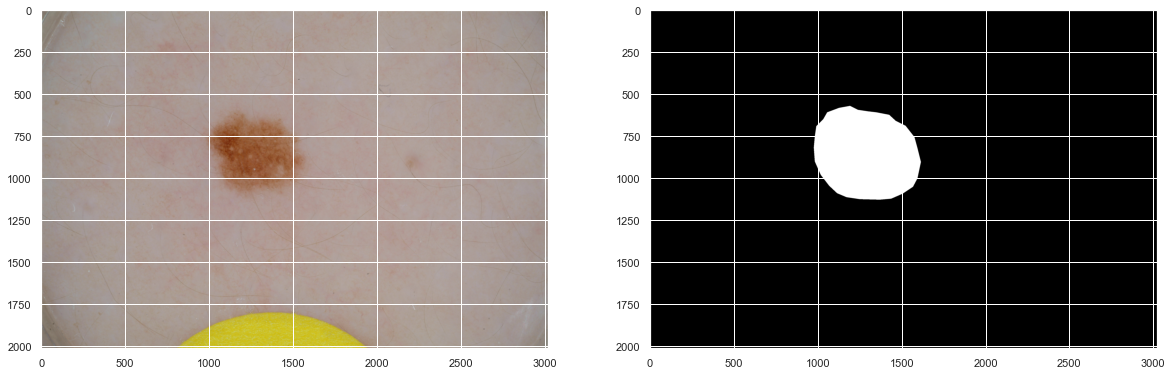

In [28]:
test = data_example["image_id"][20]

img = plt.imread(PATH["data_example_image"].format(test))
segment = plt.imread(PATH["data_example_segmentation"].format(test))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
axes[0].imshow(img)
axes[1].imshow(segment, cmap='gray');

To determine the quality of the pictures we take a look at the first 5 healthy lesions and the first 5 melanoma cancerous lesions in the example files.

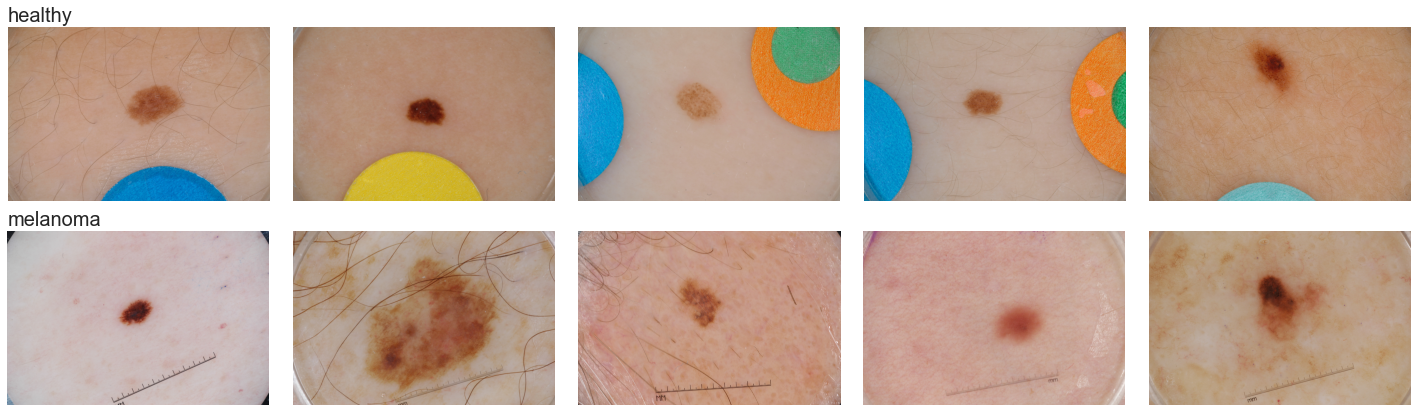

In [29]:
label = [0.0, 1.0]
label_images = []
classes = ['healthy', 'melanoma']

fig = plt.figure(figsize=(20, 20))
k = range(7)

for i in label:
    sample = data_example[data_example['melanoma'] == i]['image_id'][:5]
    label_images.extend(sample)
    
for position, ID in enumerate(label_images):
    labl = data_example[data_example['image_id'] == ID]['melanoma']
    im_sample = PATH["data_example_image"].format(ID)
    #im_sample = example_img_path + f'{ID}.jpg'
    im_sample = plt.imread(im_sample)

    plt.subplot(7, 5, position+1)
    plt.imshow(im_sample)
    plt.axis('off')

    if position%5 == 0:
        title = int(position/5)
        plt.title(classes[title], loc='left', size=20)

plt.tight_layout()
plt.show()

The pictures have a good quality, and is sufficient for our research.

## For reproduceability: Manipulating the 2017 dataset

The 2017 dataset consists, just like the example dataset, of two folders with pictures and corresponding segments and a csv file that binds pictures and segments together with and ID. The set consists of 2000 lesions and there are again three options for a lesion, it can either have melanoma, keratosis or be healthy. What has been shown above for task 0 has also been repeated for this dataset, but will not be shown here.

In [30]:
if CALCULATE_FEATURE:
    print(dataframe.shape)
    print("Number of lesions with Melanoma:", len(dataframe[dataframe["melanoma"] == 1.0]))
    print("Number of lesions with Keratosis:", len(dataframe[dataframe["seborrheic_keratosis"] == 1.0]))
    print("Number of healthy lesions:", len(dataframe[(dataframe["melanoma"] == 0.0) & (dataframe["seborrheic_keratosis"] == 0.0)]))

In [31]:
if CALCULATE_FEATURE:
    # Removes the lesions with keratosis
    dataframe = dataframe[dataframe["seborrheic_keratosis"] != 1.0]
    print(dataframe)

# Task 1: Implement two features

## The symmetry of a lesion

A for Asymmetry, is the first sign to look for in the ABCDE's of melanoma. Cancerous lesions tend to not have perfect symmetric shapes, therefore if you draw a line through the lesion, then the two halves won't match. To measure this feature on a lesion, we have come up with an algorithm that turns and flips a segment/mask of a given lesion and calculates how much mass lies outsides of the original boundaries. This is done two times, both for the vertical symmetry and the horisontal symmetry. <br>
<br>
To reduce computation time all images are rescaled largely. We can do this with confidence for this feature, because we are only interested in the shape of the lesion and not the original size. Down to a certian degree, shapes are almost not altered by rescaling. Thus making our code faster without us loosing critical information about the lesion.

To explain how the algorithm works, a toy example with a triangle is shown. N.B: It is not shown here, but our algorithm also makes sure that the lesion in the first place is turned so the longest diameter is vertical


![alt text](Images/symmetry1.JPG)

The algorithm is fed a segment/mask. A copy is made, and that picture is turned 180 degrees and flipped vertically. This is essentially the same as "folding" the segment on the middle, and calculating overlapping pixels. In our way, we do two "folds" simultaneously and therefore only have to do two calculations instead of four. To calculate the horisontal assymetry the picture is just rotated 90 degrees first, and then the above steps is copied. 

![as](Images/symmetry2.JPG)

The original segment and the turned + flipped segments is then subtracted from eachother. This results in an image consisting of pixels in either gray, black or white. This happens because we are subtracting two pictures only consisting of the color codes 0 or 1. When doing so four things can happen mathematically:

The two subtracted elements are both empty <br>
0 - 0 = 0 (gray)<br>
<br>
Matter is being subtracted from something empty <br>
0 - 1 = -1 (black)<br>
<br>
Something empty is being subtracted from matter <br>
1 - 0 = 1 (white)<br>
<br>
Matter is being subtracted from matter <br>
1 - 1 = 0 (gray)

The amount of black and white pixels are then summed up, this is the amount of assymetric pixels. The assymetric pixels are then divided by the total amount of white pixels in the original segment/mask. This shows the relative amount of asymmetric pixels. However, we wanted our feature to show how symmetric the lesion is and not how assymetric it is. To do this we subtract the relative amount of symmetric pixels from 1. Meaning the more symmetric a lesion is, the closer to 1 this algorithm will label it.

### Example

(0.658728302063351, 0.7141252982735227)

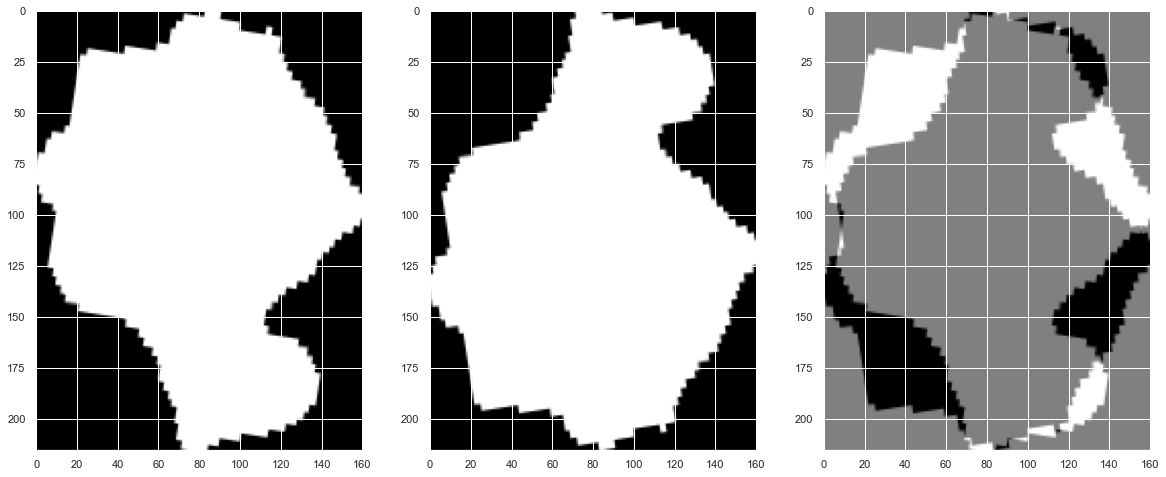

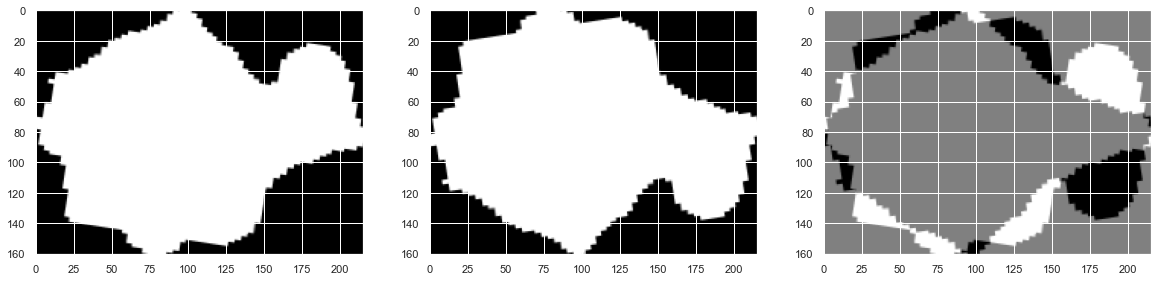

In [32]:
seg = plt.imread(PATH["data_example_segmentation"].format("ISIC_0012210"))
symmetric(seg, plot = True)

The symmetry is then calculated for every image in our data. The code below runs through all id's in the dataframe and calculates the symmetry. Takes about 15 minutes for all the pictures in our dataset. Lastly the vertical symmetry and the horisontal symmetry is added to the dataframe along with an extra column consisting of the average symmetry.

#### For reproduceability: Calculating the symmetry features for the 2017 dataset

In [33]:
if CALCULATE_FEATURE:
    vertical_symmetry = []
    horisontal_symmetry = []

    for idd in list(dataframe["image_id"]):
        seg = plt.imread(PATH["data_2017_segmentation"].format(idd))
        V, H = symmetric(seg)
        vertical_symmetry.append(V)
        horisontal_symmetry.append(H)

    dataframe["vertical_symmetry"] = vertical_symmetry
    dataframe["horisontal_symmetry"] = horisontal_symmetry
    dataframe["symmetry"] = (dataframe["vertical_symmetry"]+dataframe["horisontal_symmetry"])/2
    print(dataframe)

With the symmetry feature calculated, we can take a look at the spread of the vertical and horisontal symmetry. First we have a scatterplot of the two, and after we have a density plot of the averaged symmetry.

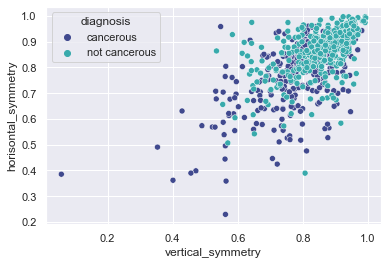

In [34]:
sns.scatterplot(x = balanced["vertical_symmetry"], y = balanced["horisontal_symmetry"], hue = balanced["diagnosis"], palette="mako");

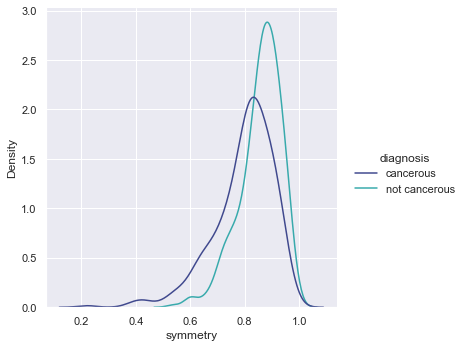

In [35]:
sns.displot(balanced, x = "symmetry", hue = "diagnosis", kind = "kde", palette="mako");

From the density plot it is clear that the two distributions have a different mean, and the cancerous lesions thends to be less symmetric. Therefore this feature looks promising in determining melanoma.

## The border of a lesion
In the ABCDE's of melanoma, B is for border, as border irrgularity is the second sign to look for. To identify this we calculated the following features:

- area
- perimeter
- radius standard deviation
- radius mean
- compactness

### Area & perimeter 
This was calculated by using Veronika's function measure_area_perimeter provided in the fyp2021p3_group08_functions.py file.

In [36]:
# load image
example_img = plt.imread('../data/example/example_segmentation/ISIC_0012099_segmentation.png') 

# calculate area and perimeter
ex_area, ex_per = measure_area_perimeter(example_img)

print('Area:', ex_area)
print('Perimiter:', ex_per)

Area: 88455.0
Perimiter: 1353.0


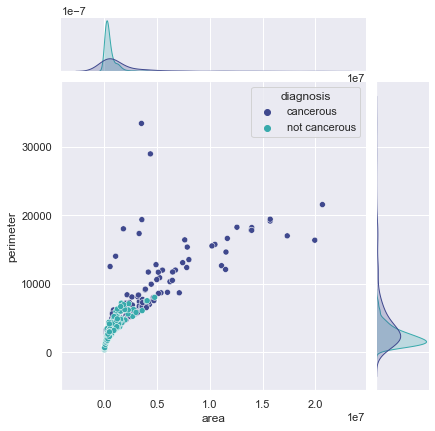

In [37]:
sns.jointplot(
    data=balanced,
    x="area", y="perimeter", hue="diagnosis",
    palette='mako'
);

### Compactness
To calculate the compactness (roundness of the lesions) we used the already avaiable values for area and perimeter in the following formula:
$$compactness = \frac{perimeter^2}{4\pi * area}$$

In [38]:
# calculate compactness
ex_comp = cal_comp(example_img)

print('Compactness:', ex_comp)

Compactness: 1.6468852592759675


When plotting the distribution of compactness we could see some deviation, but didn't seem like enough to differentiate between cancerous and no cancerous lesions.

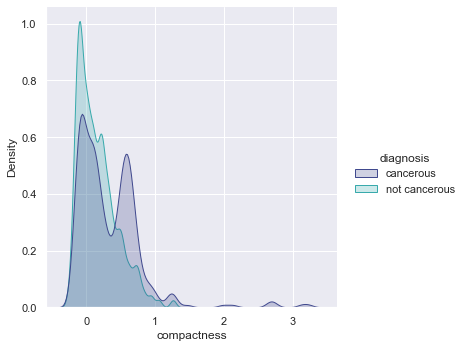

In [39]:
sns.displot(balanced, x=np.log(balanced["compactness"]), kind="kde", hue='diagnosis', bw_adjust=.5, fill=True, palette='mako');

To go further than compactness and identify more than the roundness of the lesion. We implemented the `radius_sd` feature, which measures the standard deviation of radius across the skin lesion. 

This is calculated by:
- first finding the center of the lesion and it's perimiter, 
- then measuring the distance around all pixels in the perimer and saving them into a list. 
- From the list, we calculate the mean and the standard deviation of the lesion. 

To test the function we compared a perfect circle with other lesions. It works as intended as we can see plotted below.

In [40]:
# calculate radius standard deviation
ex_rsd = radial_profile(example_img)

print('Radius standard deviation:', ex_rsd[0])
print('Radius mean:', ex_rsd[1])

Radius standard deviation: 133.00764206720316
Radius mean: 776.8977154542989


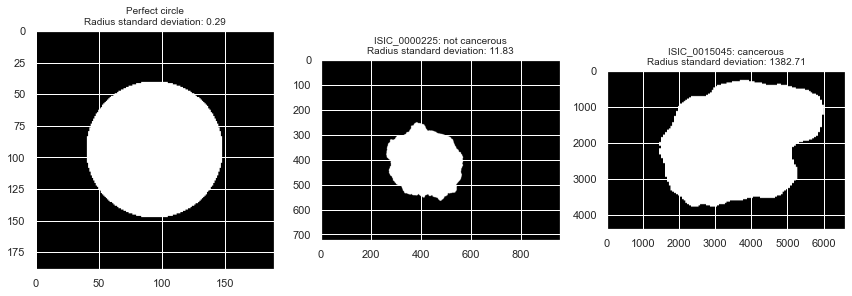

In [41]:
# perfect circle for testing
perfect_circle = plt.imread('../data/perfect_circle.png')
perfect_circle = color.rgb2gray(color.rgba2rgb(perfect_circle))
perfect_circle = (perfect_circle > 0).astype(int) # convert to binary

# get images ids for highest and lowerst radius standard deviation
max_id = balanced['image_id'].loc[balanced['radius_sd'] == max(balanced['radius_sd'])].iloc[0]
min_id = balanced['image_id'].loc[balanced['radius_sd'] == min(balanced['radius_sd'])].iloc[0]

# get images diagnosis 
max_diag = balanced['diagnosis'].loc[balanced['radius_sd'] == max(balanced['radius_sd'])].iloc[0]
min_diag = balanced['diagnosis'].loc[balanced['radius_sd'] == min(balanced['radius_sd'])].iloc[0]

# read images
max_rsd = plt.imread('../data/ISIC_0015045_segmentation.png')
min_rsd = plt.imread('../data/ISIC_0000225_segmentation.png')

# calculate radial profile
rp_circle = str(round(radial_profile(perfect_circle)[0], 2))
rp_min = radial_profile(min_rsd)
rp_max = radial_profile(max_rsd)

# plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
axes[0].imshow(perfect_circle, cmap='gray')
axes[0].set_title('Perfect circle\nRadius standard deviation: ' + rp_circle, size=10)

axes[1].imshow(min_rsd, cmap='gray')
axes[1].set_title(min_id + ': ' + min_diag + '\nRadius standard deviation: ' + str(round(rp_min[0], 2)), size=10)

axes[2].imshow(max_rsd, cmap='gray')
axes[2].set_title(max_id + ': '+ max_diag + '\nRadius standard deviation: ' + str(round(rp_max[0], 2)), size=10)

fig.tight_layout()

When comparing the empirical distiburions of compactness and radius standard deviation values, we can clearly see how the radius standard deviation has a much clear division between cancereous and non cancereous lesions in our dataset and will probably be useful when creating a classifier.

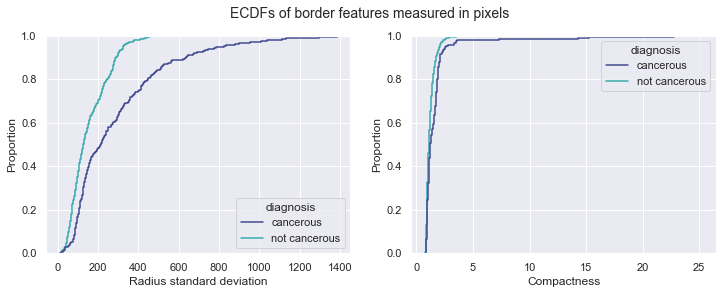

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('ECDFs of border features measured in pixels', size=14)

sns.ecdfplot(ax=axes[0], data=balanced, x="radius_sd", hue="diagnosis", palette='mako')
axes[0].set_xlabel("Radius standard deviation")

sns.ecdfplot(ax=axes[1], data=balanced, x="compactness", hue="diagnosis", palette='mako')
axes[1].set_xlabel("Compactness")

plt.show()

To reproduce the calculation of the features, the function `get_features` can be used.

In [43]:
if CALCULATE_FEATURE:
    dataframe = get_features(dataframe, 'image_id')

The feature values relating to the border can be normalised using the function below.

In [44]:
if CALCULATE_FEATURE:
    dataframe = norm_area_etc(dataframe)
    print(dataframe)

## The color of a lesion
C for Color, is the third sign to look for in the ABCDE's of melanoma. Normal moles are generally a uniform tan, brown or black color, while cancerous lesions tend to consist of many colors or an uneven distribution of color. An indicator of cancer can also be a change of color of the lesion. <br>
<br>
The original images and the corresponding segmentation image is overlapped to mask the original image to only show the lesion, leaving the rest black. See the function <code>image_segmentation</code>.<br>
This mask is then used to measure the color of all pixels in the lesion, meaning the RGB-value of each and every pixel in the lesion is found and each unique RGB-value counted. These are then used to find various indicator of variation in color:
<li> <code>measure_color[0]</code> returns the relative color variance, meaning the number of unique RGB-values in the lesion devided with the number of total pixels the lesion make up.</li>
<li> <code>measure_color[1:4]</code> returns the average of the R, G and B values found in the lesion.</li>
<li> <code>measure_color[4:7]</code> returns the standard deviation of the R, G and B values found in the lesion.</li>
<li> <code>measure_color[7]</code> returns the average of the standard deviations found of each R, G and B values.</li>
<li> <code>measure_color[8:11]</code> returns the range the R, G and B values found in the lesion span over.</li>
<li> <code>measure_color[11:14]</code> returns the percentage the R, G and B values found in the lesion each make up of the total values.</li>
<li> <code>measure_color[14]</code> returns the ratio of r-values found in the lesion that is below 50 in relation to the total number of r-values of the lesion.</li>
<li> <code>measure_color[15]</code> returns the ratio of b-values found in the lesion that is above 150 in relation to the total number of b-values of the lesion.</li>
<li> <code>measure_color[16]</code> all unique RGB-values found in the lesion and the corresponding number of pixels it was found in. </li>
<br><br>
Some measurement are already normalized, while some will be later.<br><br>
To explore the color distribution of healthy and melanoma lesions the <code>plot_colors</code>-function plots the RGB-values in a 3D plot with the plots having the corresponding color to the value.<br>


The input images before-hand could have been cropped to primarly only show the lesion and then all been given the same dimensions, but instead the different pixel measurements have been calculated with the total amount of pixels found in the lesion in mind to get a somewhat even distribution regardless of this. Including the cropping of the image before hand was found to worsen the running time of the code. 

### Example: Visualizing

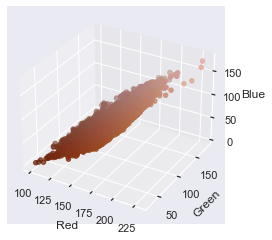

None


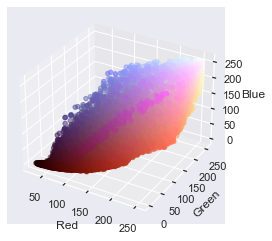

None


In [45]:
melanoma_img = PATH["data_example_image"].format('ISIC_0014931')
melanoma_seg = PATH["data_example_segmentation"].format('ISIC_0014931')
healthy_img = PATH["data_example_image"].format('ISIC_0001769')
healthy_seg = PATH["data_example_segmentation"].format('ISIC_0001769')
print(plot_colors(healthy_img, healthy_seg))
print(plot_colors(melanoma_img, melanoma_seg))

The melanoma lesion has clearly a bigger range of color than the healthy lesion. Regardless of the size the lesion take up of the image.

### Example: Measurements

In [46]:
print("Relative color variance:", measure_color(healthy_img, healthy_seg)[0])
print("Average R, G and B values:", measure_color(healthy_img, healthy_seg)[1:4])
print("Standard deviation of R, G and B:", measure_color(healthy_img, healthy_seg)[4:7])
print("Average of the standard deviation:", measure_color(healthy_img, healthy_seg)[7])
print("Range of R, G and B:", measure_color(healthy_img, healthy_seg)[8:11])
print("Percentage of R, G and B values:", measure_color(healthy_img, healthy_seg)[11:14])
print("Ratio of r-values below 50:", measure_color(healthy_img, healthy_seg)[14])
print("Ratio of b-values above 150:", measure_color(healthy_img, healthy_seg)[15])

Relative color variance: 0.037102146558105106
Average R, G and B values: (157, 97, 67)
Standard deviation of R, G and B: (16.644739051011157, 23.608733579535137, 26.063657747558587)
Average of the standard deviation: 22.10571012603496
Range of R, G and B: (128, 149, 170)
Percentage of R, G and B values: (0.4893262716148277, 0.3013512063553917, 0.20932252202978055)
Ratio of r-values below 50: 0.0
Ratio of b-values above 150: 0.0003740648379052369


The different color measurements is then calculated for every image in our data. The code below runs through all id's in the dataframe and calculates the color. Takes about 15 minutes for all the pictures in our dataset. Lastly the results is normalized (if not already) and added to the dateframe.

In [47]:
if CALCULATE_FEATURE: 
    relative_color_variance = []
    r_average = []
    g_average = []
    b_average = []
    r_std = []
    g_std = []
    b_std = []
    average_std = []
    r_range = []
    g_range = []
    b_range = []
    r_pct = []
    g_pct = []
    b_pct = []
    r_low = []
    b_high = []

    for i in dataframe['image_id']:
       rel_col_var, r_avg, g_avg, b_avg, r_sd, g_sd, b_sd, avg_std, r_ran, g_ran, b_ran, r_pc, g_pc, b_pc, low_r, high_b = measure_color(PATH["data_2017_image"].format(i), PATH["data_2017_segmentation"].format(i))[0:16]
       relative_color_variance.append(round(rel_col_var, 4))
       r_average.append(round(r_avg, 4))
       g_average.append(round(g_avg, 4))
       b_average.append(round(b_avg, 4))
       r_std.append(round(r_sd, 4))
       g_std.append(round(g_sd, 4))
       b_std.append(round(b_sd, 4))
       average_std.append(round(avg_std, 4))
       r_range.append(round(r_ran, 4))
       g_range.append(round(g_ran, 4))
       b_range.append(round(b_ran, 4))
       r_pct.append(round(r_pc, 4))
       g_pct.append(round(g_pc, 4))
       b_pct.append(round(b_pc, 4))
       r_low.append(round(low_r, 4))
       b_high.append(round(high_b, 4))

In [48]:
if CALCULATE_FEATURE: 
    # normalizing average R, G and B
    norm_r_average = [(i-min(r_average))/(max(r_average)-min(r_average)) for i in r_average]
    norm_g_average = [(i-min(g_average))/(max(g_average)-min(g_average)) for i in g_average]
    norm_b_average = [(i-min(b_average))/(max(b_average)-min(b_average)) for i in b_average]

    # normalizing std of R, G and B
    norm_r_std = [(i-min(r_std))/(max(r_std)-min(r_std)) for i in r_std]
    norm_g_std = [(i-min(g_std))/(max(g_std)-min(g_std)) for i in g_std]
    norm_b_std = [(i-min(b_std))/(max(b_std)-min(b_std)) for i in b_std]
    norm_average_std = [(i-min(average_std))/(max(average_std)-min(average_std)) for i in average_std]

    # normalizing average R, G and B
    norm_r_range = [(i-min(r_range))/(max(r_range)-min(r_range)) for i in r_range]
    norm_g_range = [(i-min(g_range))/(max(g_range)-min(g_range)) for i in g_range]
    norm_b_range = [(i-min(b_range))/(max(b_range)-min(b_range)) for i in b_range]

In [49]:
# adding to dataframe
if CALCULATE_FEATURE:
    dataframe['relative_color_variance'] = relative_color_variance
    dataframe['r_average'] = norm_r_average
    dataframe['g_average'] = norm_g_average
    dataframe['b_average'] = norm_b_average
    dataframe['r_std'] = norm_r_std
    dataframe['g_std'] = norm_g_std
    dataframe['b_std'] = norm_b_std
    dataframe['average_std'] = norm_average_std
    dataframe['r_range'] = norm_r_range
    dataframe['g_range'] = norm_g_range
    dataframe['b_range'] = norm_b_range
    dataframe['r_pct'] = r_pct
    dataframe['g_pct'] = g_pct
    dataframe['b_pct'] = b_pct
    dataframe['r_low'] = r_low
    dataframe['b_high'] = b_high

    print(dataframe)

Now plotting some of the calculated color features. <br>
First is a density plot of the relative color variance. Then pairplots for: 1) the standard deviation, 2 ) the range, and 3 ) percentage - all of the R, G and B-values. Lastly a scatterplot of the percentage of R-values vs. the percentage of the B-values to further observe this. 

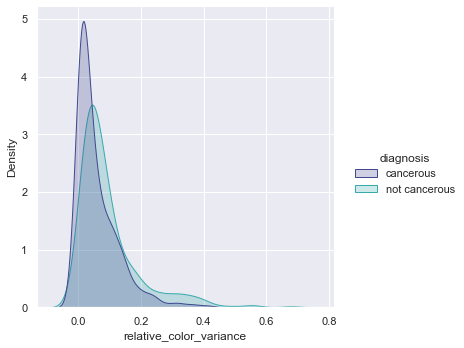

In [50]:
sns.displot(balanced, x = "relative_color_variance", hue = "diagnosis", kind = "kde", palette ="mako", fill=True);

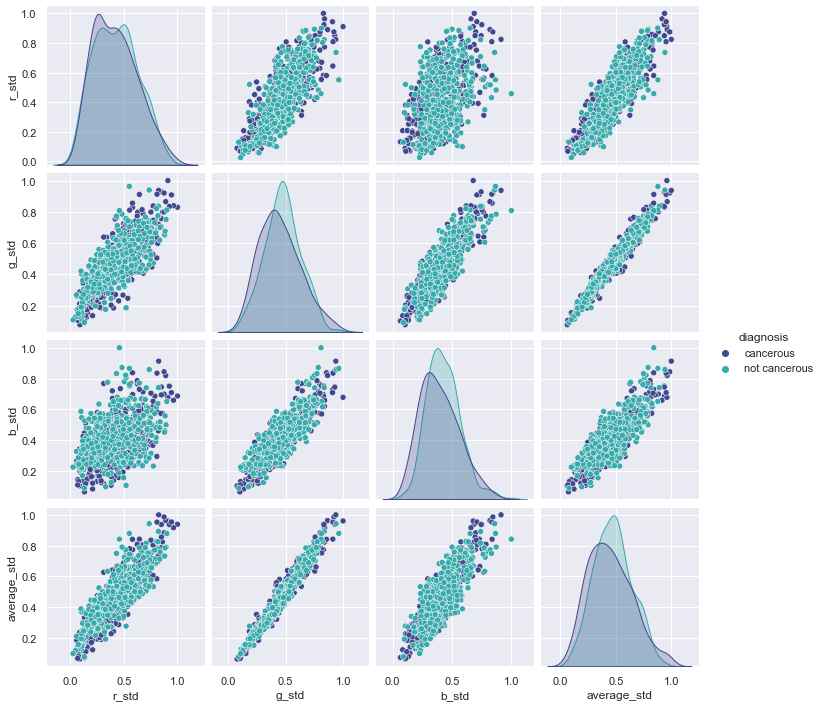

In [51]:
sns.pairplot(balanced, hue = "diagnosis", 
    x_vars=["r_std", "g_std", "b_std", "average_std"], y_vars=["r_std", "g_std", "b_std", "average_std"], palette ="mako");

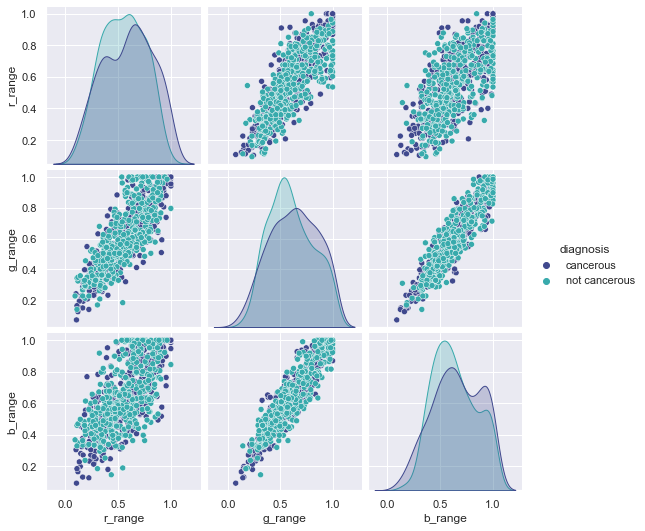

In [52]:
sns.pairplot(balanced, hue = "diagnosis",
    x_vars=["r_range", "g_range", "b_range"], y_vars=["r_range", "g_range", "b_range"], palette="mako");

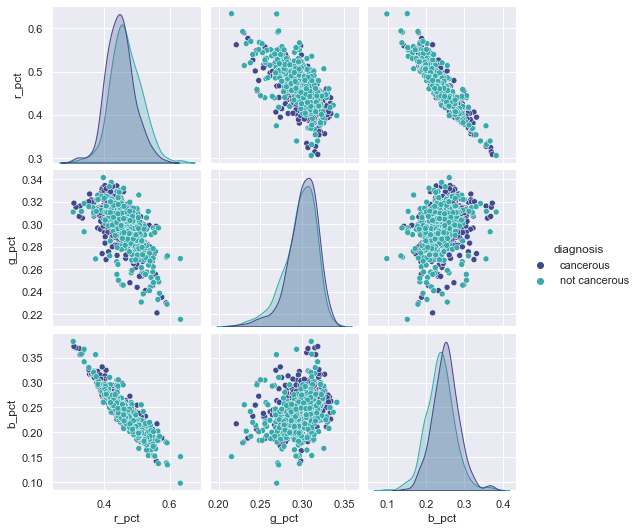

In [53]:
sns.pairplot(balanced, hue = "diagnosis", 
    x_vars=["r_pct", "g_pct", "b_pct"], y_vars=["r_pct", "g_pct", "b_pct"], palette ="mako");

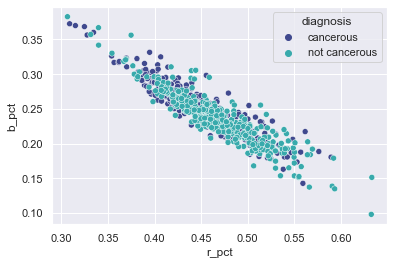

In [54]:
sns.scatterplot(x = balanced["r_pct"], y = balanced["b_pct"], hue = balanced["diagnosis"], palette="mako");

From the different plots most values seem to be relative similar for cancerous and not cancerous lesions. <br><br>
<b>Relative color variance:</b> Cancerous lesions seem to have a bigger distribution of the relative color in the lower than not cancerous.<br>
<b>Standard deviation:</b> Cancerous lesions seem to have a bigger distribution of standard deviation for all individual RGB-values as well as average standard devation in the lower than not cancerous lesions.<br>
<b>Range:</b> Cancerous lesions seem to have its distribution of values in the higher range of R, G and B than not cancerous lesions. Meaning the range of color tend to be bigger in cancerous lesions than in not cancerous lesions.<br>
<b>Percentage:</b> Specifically for the single scatterplot of R-pct vs. B-pct a slight tendency for the not cancerous plots to be of bigger r-pct than b-pct and cancerous plots to be of bigger b-pct than r-pct. This also seems to be the case for the density plots in the pairplot for the R, G and B-percentages: A bigger distribution of R-percentage is set lower for cancerous than for not cancerous, and reverse when looking at the B-percentage. <br>

## Final dataframe

In [55]:
if CALCULATE_FEATURE:
    print(dataframe)

# Task 2: Predict the diagnosis

We split the data into development and test data using the train_test_split function from sklearn.model_selection. The development data was then split into a validation set and a training set. We decided to feature select on a lot of features, such as area, perimeter, compactness and symmetry.
<br> <br>
We set the random state to be 42, to get reproducibility in our results. we also set the test size to be 0.2, which means our test data is 20% of our raw data. The remaining 80% our model is going to train and validate on.

In [56]:
non_balanced_df

,image_id,melanoma,seborrheic_keratosis,radius_sd,radius_mean,area,perimeter,compactness,diagnosis_sum,diagnosis,...,b_std,average_std,r_range,g_range,b_range,r_pct,g_pct,b_pct,r_low,b_high
0,ISIC_0000000,0.0,0.0,142.796002,373.374403,364956.0,2258.0,1.111725,0.0,not melanoma,...,0.620079,0.660033,0.567568,0.592233,0.710145,0.3399,0.3183,0.3418,0.0932,0.2144
1,ISIC_0000001,0.0,0.0,88.198414,229.017981,53432.0,914.0,1.244174,0.0,not melanoma,...,0.230567,0.367522,0.522523,0.378641,0.396135,0.4428,0.3104,0.2469,0.1328,0.0000
2,ISIC_0000002,1.0,0.0,110.927367,304.913068,237402.0,2071.0,1.437692,1.0,melanoma,...,0.564853,0.480467,0.391892,0.470874,0.666667,0.3697,0.3071,0.3233,0.0005,0.2243
3,ISIC_0000003,0.0,0.0,166.513656,346.623696,260712.0,1848.0,1.042397,0.0,not melanoma,...,0.427639,0.550965,0.648649,0.606796,0.545894,0.4319,0.3204,0.2477,0.0024,0.0393
4,ISIC_0000004,1.0,0.0,79.699652,305.763837,269484.0,1746.0,0.900214,1.0,melanoma,...,0.523281,0.592497,0.905405,0.893204,0.859903,0.4066,0.2685,0.3249,0.0081,0.4463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,ISIC_0015190,1.0,0.0,1093.195716,2377.036328,12575987.0,18268.0,2.111690,1.0,melanoma,...,0.436331,0.635530,0.815315,0.728155,0.671498,0.5159,0.2778,0.2063,0.0013,0.0075
1742,ISIC_0015200,1.0,0.0,1133.852851,2924.837093,20680044.0,21573.0,1.790852,1.0,melanoma,...,0.844189,0.985986,0.990991,1.000000,1.000000,0.3863,0.3225,0.2911,0.0294,0.3748
1743,ISIC_0015204,1.0,0.0,638.148297,2216.116253,13977416.0,17821.0,1.808121,1.0,melanoma,...,0.912955,1.000000,0.981982,1.000000,1.000000,0.3905,0.3102,0.2994,0.0168,0.3873
1744,ISIC_0015219,1.0,0.0,1007.059034,2076.991674,8019976.0,13546.0,1.820703,1.0,melanoma,...,0.484206,0.638342,0.900901,0.995146,1.000000,0.5013,0.2439,0.2548,0.0132,0.0368


In [57]:
df = non_balanced_df
features = df.drop(["image_id", "melanoma", "seborrheic_keratosis", "diagnosis_sum", "diagnosis"], axis = 1)
X_dev, X_test, y_dev, y_test = train_test_split(features, df["melanoma"], stratify=df["melanoma"], random_state=42,test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev, random_state=42, test_size=0.2)

## Feature selection

Train a class for k best features, may be errors here since, the class will pick the highest scores of which can be correlated features, since they will have almost the same score, which then will not result in poor results.

In [58]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train, y_train);

Then we ascess the scores and plot them

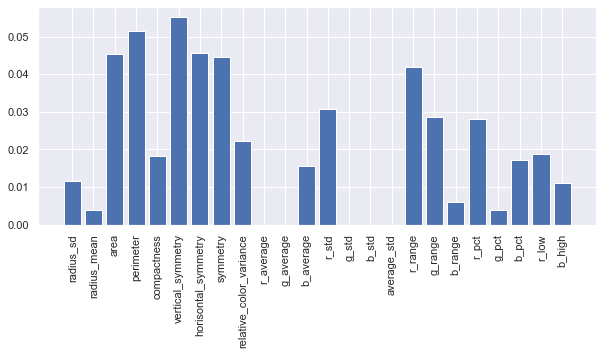

In [59]:
scores = selector.scores_
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(features.columns, scores, label=r'Feature score')
plt.xticks(rotation=90); 

In [60]:
sorted(zip(selector.scores_, features.columns), reverse=True)[:20]

[(0.055137858267301, 'vertical_symmetry'),
 (0.051469917672506416, 'perimeter'),
 (0.04570837916890813, 'horisontal_symmetry'),
 (0.045361909540772016, 'area'),
 (0.044552255792207784, 'symmetry'),
 (0.04194604524738188, 'r_range'),
 (0.03088548901880772, 'r_std'),
 (0.028516489013443946, 'g_range'),
 (0.028056586289155083, 'r_pct'),
 (0.02217635435740095, 'relative_color_variance'),
 (0.01888799369320071, 'r_low'),
 (0.018355588496190567, 'compactness'),
 (0.01727688959758633, 'b_pct'),
 (0.01555380781810256, 'b_average'),
 (0.011652163417247507, 'radius_sd'),
 (0.011194698868453257, 'b_high'),
 (0.0060020915541085795, 'b_range'),
 (0.003978824819341309, 'g_pct'),
 (0.003897636858064546, 'radius_mean'),
 (0.0, 'r_average')]

In [61]:
X_train = X_train[["perimeter","relative_color_variance", "symmetry"]]
X_test = X_test[["perimeter","relative_color_variance", "symmetry"]]
X_val = X_val[["perimeter","relative_color_variance", "symmetry"]]

Here we see that the features radius_sd, r_average and symmetry scored the highest, these features are not correlated, so we can go through with these. However, we see that relative_color_variance incorporates all the color features into one, so will use this one instead of r_average

Initialize, score dictionaryes to store the results from the different classifier tests

In [62]:
val_acc_scores = {}
val_auc_scores = {}

## k-nearest neighbors

How KNN works: 

A lesion is classified by a plurality vote of its neighbors, with the lesion being assigned to the class most common among its k nearest neighbors (k is a positive integer). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

Run multiple KNN fits, to find the best parameter

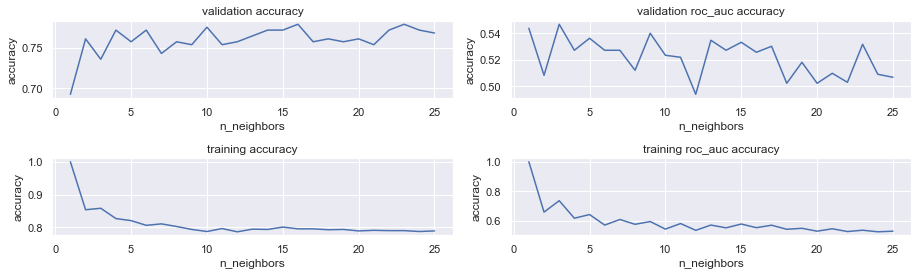

In [63]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    val_predict = knn.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = knn.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

plot_test_ML(val_acc, val_auc, train_acc, train_auc, "n_neighbors")

- A low value of k would mean that noise will have a higher influence on the result
- A large k value will make the predicting computationally expensive. 

Here we decide to go for n_neighbors=5, since it is fairly accurate at that number of neighbors, and it is also not overfitted. Which is exactly what we want.

In [64]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

val_prediction = KNN.predict(X_val)
val_acc_scores["KNN"] = accuracy_score(y_val, val_prediction)
val_auc_scores["KNN"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["KNN"], val_auc_scores["KNN"]))

accuracy: 0.7571428571428571
roc_accuracy: 0.5363636363636363


Here we train the KNN with our training data, we predict using our test data in the trained KNN and we get an accuracy_score for this KNN on our test data.

We see the simple accuracy_score is a lot higher than the roc_accuracy score. Roc_auc_accuracy score shows how accurate our model is in correctly predicting positive cases. This could be caused by the skewness in our data. We have a lot more healthy than cancerous lesions, which would make our model better at prediction healthy lesions. Therefore We then assume that our model predicts basically all lesions to be healthy. Thus getting a high accuracy score, but a low roc_accuracy score. It is only in the extreme cases where the model is sure that that the lesions has cancer, that it will predict the lesion to be cancerous.

As an example let's see what the model predicts on a randomly picked sample in our data

In [65]:
print(KNN.predict(pd.DataFrame(df.iloc[1742][["radius_sd","relative_color_variance", "symmetry"]]).T))

[0.]


The KNN model predicts this lesion to be 0 [not cancerous]

In [66]:
pd.DataFrame(df.iloc[1742]).T

,image_id,melanoma,seborrheic_keratosis,radius_sd,radius_mean,area,perimeter,compactness,diagnosis_sum,diagnosis,...,b_std,average_std,r_range,g_range,b_range,r_pct,g_pct,b_pct,r_low,b_high
1742,ISIC_0015200,1.0,0.0,1133.852851,2924.837093,20680044.0,21573.0,1.790852,1.0,melanoma,...,0.844189,0.985986,0.990991,1.0,1.0,0.3863,0.3225,0.2911,0.0294,0.3748


Though when we find the lesion in our data, it was diagnosed to be cancerous. This is because our KNN has an accuracy score of 75%, so the model will be wrong in roughly 25% cases.

## Decision Tree Classifier

A Decision Tree Classifier works in the sense that the algorithm creates a lot of if-statements in a tree-like structure

![a](Images/DTC.png)

Run multiple Decision Tree Classifier fits, to find the best parameter

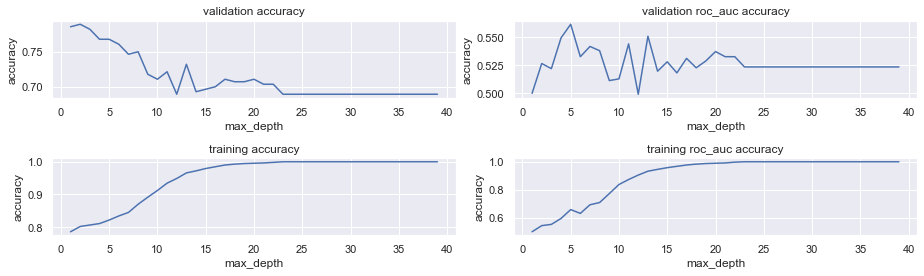

In [67]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    DTC = DecisionTreeClassifier(random_state=42, max_depth=i)
    DTC.fit(X_train, y_train)
    
    val_predict = DTC.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = DTC.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

Here we have two options, we can go for a very simple Decision Tree, meaning low depth or we could go with a complex, meaning a high depth.  
We decide to go for max depth 25, since the model converges around 25 and the model will not be overfitted, which we see on the validation data.

In [68]:
DTC = DecisionTreeClassifier(random_state=42, max_depth=25)
DTC.fit(X_train, y_train)
val_prediction = DTC.predict(X_val)
val_acc_scores["DTC"] = accuracy_score(y_val, val_prediction)
val_auc_scores["DTC"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_auc_accuracy: {}".format(val_acc_scores["DTC"], val_auc_scores["DTC"]))

accuracy: 0.6892857142857143
roc_auc_accuracy: 0.5234848484848484


Here we see the simple accuracy is 0.69 and that the roc_auc_accuracy is 0.52 

## Random Forest Classifier

The Random Forest Classifier works by constructing a lot of random decision trees at training time and outputting the class that is the mode of the classes (classification) of the individual trees.

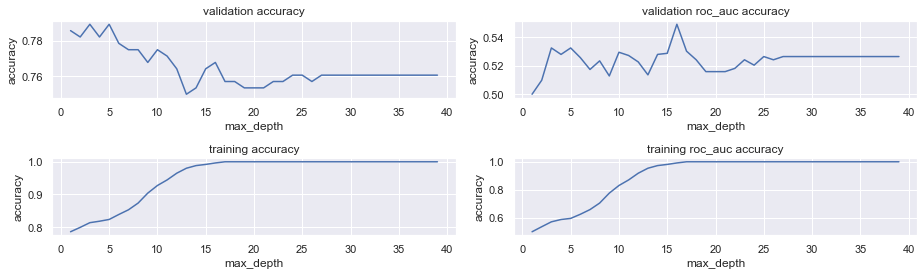

In [69]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    RFC = RandomForestClassifier(random_state=42, max_depth=i)
    RFC.fit(X_train, y_train)
    
    val_predict = RFC.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = RFC.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

Here we again go for a high depth for high accuracy.

In [70]:
RFC = RandomForestClassifier(max_depth=25, random_state=42)
RFC.fit(X_train, y_train)
val_prediction = RFC.predict(X_val)
val_acc_scores["RFC"] = accuracy_score(y_val, val_prediction)
val_auc_scores["RFC"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["RFC"], val_auc_scores["RFC"]))

accuracy: 0.7607142857142857
roc_accuracy: 0.5265151515151515


Here we see the simple accuracy is 0.76 and that the roc_auc_accuracy is 0.526

## C-Support Vector Classification

The objective of the support vector machine algorithm is to find a hyperplane(plane of N-1 dimensions, where N is the number of features) in an N-dimensional space(N being the number of features) that distinctly classifies the data points. The C term is then how much the penalty for getting a wrong plane and how much it corrects the next plane.

![a](Images/SVM.png)

![a](Images/SVM2.png)

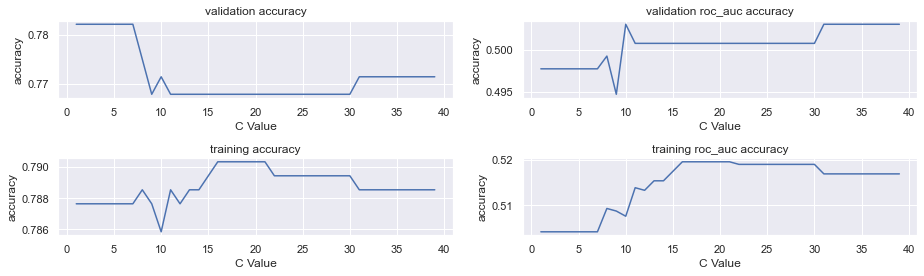

In [71]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    SV = SVC(C=i, random_state=42)
    SV.fit(X_train, y_train)
    
    val_predict = SV.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = SV.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

Here we decide for a C value of 1

In [72]:
SV = SVC(C= 1, random_state=42) 
SV.fit(X_train, y_train)
val_prediction = SV.predict(X_val)
val_acc_scores["SV"] = accuracy_score(y_val, val_prediction)
val_auc_scores["SV"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["SV"], val_auc_scores["SV"]))

accuracy: 0.7821428571428571
roc_accuracy: 0.49772727272727274


Here we see the simple accuracy is 0.782 and that the roc_auc_accuracy is 0.497

## Logistical Regression

Logistical Regression is a probabilistic regression, where a class will fall within a given range, then given the probability it was given it is then classified on the basis of the range (pictures found [here](https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148#:~:text=Logistic%20regression%20is%20a%20classification,Fraud%2C%20Tumor%20Malignant%20or%20Benign.))

![a](Images/LR3.gif)

![a](Images/LR.jpeg)

Lets say our model finds a threshhold (where the classes shift) of 0.5, then a value of 0.6 will be melanoma and a value of 0.4 will be healthy (This is not the case in our case, just an example)

![a](Images/LR2.png)

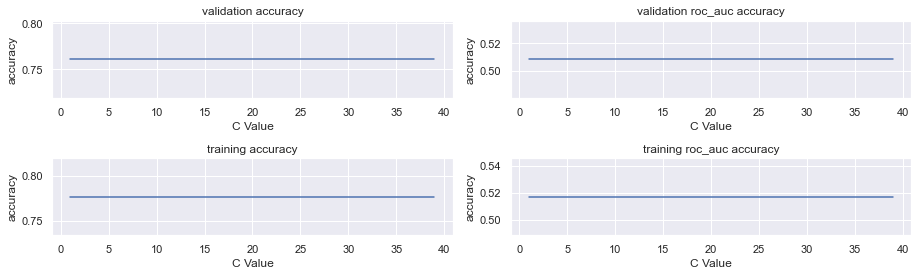

In [73]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    LR = LogisticRegression(C=i, random_state=42)
    LR.fit(X_train, y_train)
    
    val_predict = LR.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = LR.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

Here we see the penalty term C, is constant, thus we pick a C-value of 1, given that it is not overfitted and also not underfit, and the penalty term C is harsh but not too harsh.

In [74]:
LR = LogisticRegression(C=1, random_state=42)
LR.fit(X_train, y_train)
val_prediction = LR.predict(X_val)
val_acc_scores["LR"] = accuracy_score(y_val, val_prediction)
val_auc_scores["LR"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["LR"], val_auc_scores["LR"]))

accuracy: 0.7607142857142857
roc_accuracy: 0.5083333333333333


Here we see the simple accuracy is 0.761 and that the roc_auc_accuracy is 0.508

## Balanced data

We assume that the reason that our roc_auc_accuracy_score is so low in the preceding sections, is because of the skewded ratio between healthy and melanoma cases in the data. This has made our model better at classifying healthy lesions compared to cancerous lesions. In perspective, this could also cause the model become a "lazy" model. Meaning that it just predicts everything to be healthy, thus gets a high accuracy score, but low roc_auc_auccuracy score. Our idea is therefore, to reduce the number of healthy lesions to the same number as melanoma lesions. Thus we create a balanced data set.

In [75]:
non_balanced_df.shape
non_balanced_df["melanoma"].value_counts()

0.0    1372
1.0     374
Name: melanoma, dtype: int64

Our goal is therefore to check whether having a balanced data set, meaning the ratio between healthy and cancerous lesions is 1:1, increases the roc_accuracy_score.

Disclaimer: the simple accuracy score will be equal to the roc_auc_auccuracy_score when the data is balanced

In [76]:
balanced = pd.read_csv(PATH["balanced_data_melanoma"])

We see that the data is indeed balanced

In [77]:
balanced.shape
balanced["melanoma"].value_counts()

0.0    374
1.0    374
Name: melanoma, dtype: int64

Here we do the exact same steps as with the unbalanced data.

In [78]:
df = balanced
features = df.drop(["image_id", "melanoma", "seborrheic_keratosis", "diagnosis_sum", "diagnosis"], axis = 1)
X_dev, X_test_balanced, y_dev, y_test_balanced = train_test_split(features, df["melanoma"], stratify=df["melanoma"], random_state=42,test_size=0.2)

X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(X_dev, y_dev, stratify=y_dev, test_size=0.2, random_state=42)

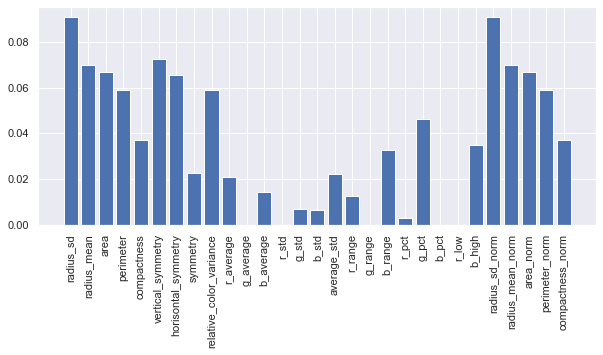

In [79]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train_balanced, y_train_balanced)
scores = selector.scores_
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(features.columns, scores, label=r'Feature score')
plt.xticks(rotation=90);

In [80]:
sorted(zip(selector.scores_, features.columns), reverse=True)[:20]

[(0.09079256061331198, 'radius_sd_norm'),
 (0.09079256061331198, 'radius_sd'),
 (0.07254392492717798, 'vertical_symmetry'),
 (0.07005598679222702, 'radius_mean_norm'),
 (0.07005598679222702, 'radius_mean'),
 (0.06690329883151547, 'area_norm'),
 (0.06690329883151547, 'area'),
 (0.06554788685375024, 'horisontal_symmetry'),
 (0.0590963441666672, 'perimeter'),
 (0.05900075127338078, 'relative_color_variance'),
 (0.058943515823462356, 'perimeter_norm'),
 (0.0461124618063844, 'g_pct'),
 (0.03705783202030566, 'compactness_norm'),
 (0.03705783202030566, 'compactness'),
 (0.03498869751191713, 'b_high'),
 (0.03264407206584341, 'b_range'),
 (0.02281768412503804, 'symmetry'),
 (0.022296754982108258, 'average_std'),
 (0.020895428780757674, 'r_average'),
 (0.014112155104178736, 'b_average')]

For the balanced data set, we see that the best features are now: "radius_sd", "vertical_symmetry" and "relative_color_variance". Now we will go through all the classifiers again with the balanced data set. Essentially repeating what we just did with the normal data set.

In [81]:
X_train_balanced = X_train_balanced[["radius_sd","vertical_symmetry", "relative_color_variance"]]
X_test_balanced = X_test_balanced[["radius_sd","vertical_symmetry", "relative_color_variance"]]
X_val_balanced = X_val_balanced[["radius_sd","vertical_symmetry", "relative_color_variance"]]

### k-nearest neighbors

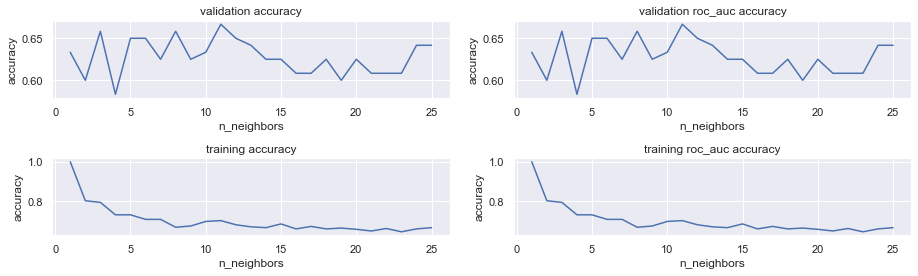

In [82]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for k in range(1,26):
    knn_balanced = KNeighborsClassifier(n_neighbors=k)
    knn_balanced.fit(X_train_balanced, y_train_balanced)
    
    val_predict = knn_balanced.predict(X_val_balanced)
    val_acc.append(accuracy_score(y_val_balanced, val_predict))
    val_auc.append(roc_auc_score(y_val_balanced, val_predict))
    
    train_predict = knn_balanced.predict(X_train_balanced)
    train_acc.append(accuracy_score(y_train_balanced, train_predict))
    train_auc.append(roc_auc_score(y_train_balanced, train_predict))

plot_test_ML(val_acc, val_auc, train_acc, train_auc, "n_neighbors")

In [83]:
KNN_balanced = KNeighborsClassifier(n_neighbors=5)
KNN_balanced.fit(X_train_balanced, y_train_balanced)

val_prediction = KNN_balanced.predict(X_val_balanced)
val_acc_scores["KNN_balanced"] = accuracy_score(y_val_balanced, val_prediction)
val_auc_scores["KNN_balanced"] = roc_auc_score(y_val_balanced, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["KNN_balanced"], val_auc_scores["KNN_balanced"]))

accuracy: 0.65
roc_accuracy: 0.65


### Decision Tree Classifier

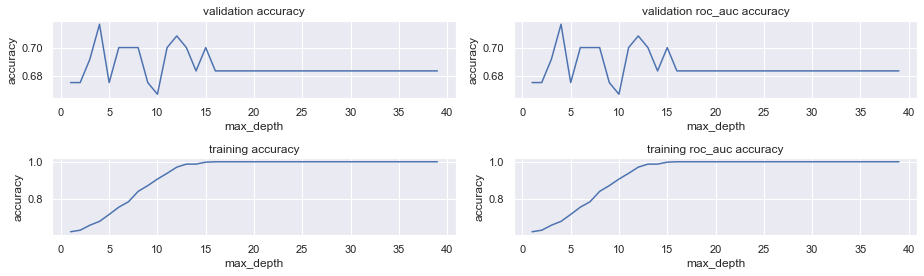

In [84]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    DTC_balanced = DecisionTreeClassifier(random_state=42, max_depth=i)
    DTC_balanced.fit(X_train_balanced, y_train_balanced)
    
    val_predict = DTC_balanced.predict(X_val_balanced)
    val_acc.append(accuracy_score(y_val_balanced, val_predict))
    val_auc.append(roc_auc_score(y_val_balanced, val_predict))
    
    train_predict = DTC_balanced.predict(X_train_balanced)
    train_acc.append(accuracy_score(y_train_balanced, train_predict))
    train_auc.append(roc_auc_score(y_train_balanced, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

In [85]:
DTC_balanced = DecisionTreeClassifier(random_state=42, max_depth=15)
DTC_balanced.fit(X_train_balanced, y_train_balanced)
val_prediction = DTC_balanced.predict(X_val_balanced)
val_acc_scores["DTC_balanced"] = accuracy_score(y_val_balanced, val_prediction)
val_auc_scores["DTC_balanced"] = roc_auc_score(y_val_balanced, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["DTC_balanced"], val_auc_scores["DTC_balanced"]))

accuracy: 0.7
roc_accuracy: 0.7000000000000001


### Random Forest Classifier

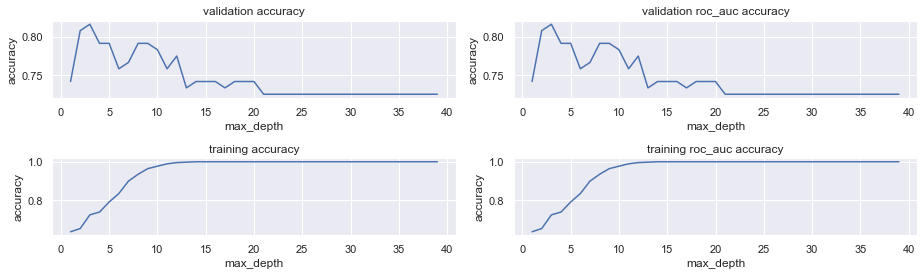

In [86]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    RFC_balanced = RandomForestClassifier(random_state=42, max_depth=i)
    RFC_balanced.fit(X_train_balanced, y_train_balanced)
    
    val_predict = RFC_balanced.predict(X_val_balanced)
    val_acc.append(accuracy_score(y_val_balanced, val_predict))
    val_auc.append(roc_auc_score(y_val_balanced, val_predict))
    
    train_predict = RFC_balanced.predict(X_train_balanced)
    train_acc.append(accuracy_score(y_train_balanced, train_predict))
    train_auc.append(roc_auc_score(y_train_balanced, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

In [87]:
RFC_balanced = RandomForestClassifier(max_depth=20, random_state=42)
RFC_balanced.fit(X_train_balanced, y_train_balanced)
val_prediction = RFC_balanced.predict(X_val_balanced)
val_acc_scores["RFC_balanced"] = accuracy_score(y_val_balanced, val_prediction)
val_auc_scores["RFC_balanced"] = roc_auc_score(y_val_balanced, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["RFC_balanced"], val_auc_scores["RFC_balanced"]))

accuracy: 0.7416666666666667
roc_accuracy: 0.7416666666666667


### C-Support Vector Classification

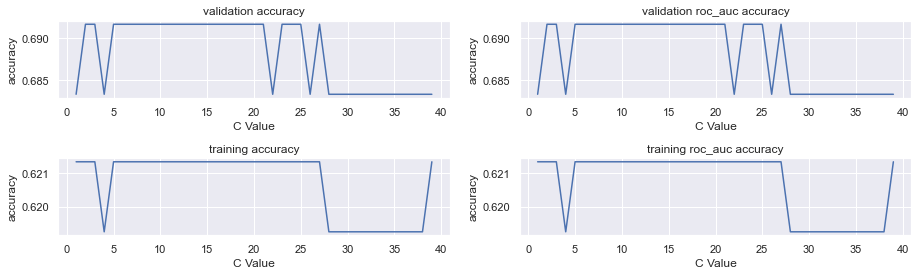

In [88]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    SV = SVC(C=i, random_state=42)
    SV.fit(X_train_balanced, y_train_balanced)
    
    val_predict = SV.predict(X_val_balanced)
    val_acc.append(accuracy_score(y_val_balanced, val_predict))
    val_auc.append(roc_auc_score(y_val_balanced, val_predict))
    
    train_predict = SV.predict(X_train_balanced)
    train_acc.append(accuracy_score(y_train_balanced, train_predict))
    train_auc.append(roc_auc_score(y_train_balanced, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

In [89]:
SV_balanced = SVC(C = 2, random_state=42) 
SV_balanced.fit(X_train_balanced, y_train_balanced)
val_prediction = SV_balanced.predict(X_val_balanced)
val_acc_scores["SV_balanced"] = accuracy_score(y_val_balanced, val_prediction)
val_auc_scores["SV_balanced"] = roc_auc_score(y_val_balanced, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["SV_balanced"], val_auc_scores["SV_balanced"]))

accuracy: 0.6916666666666667
roc_accuracy: 0.6916666666666665


### Logistical regression

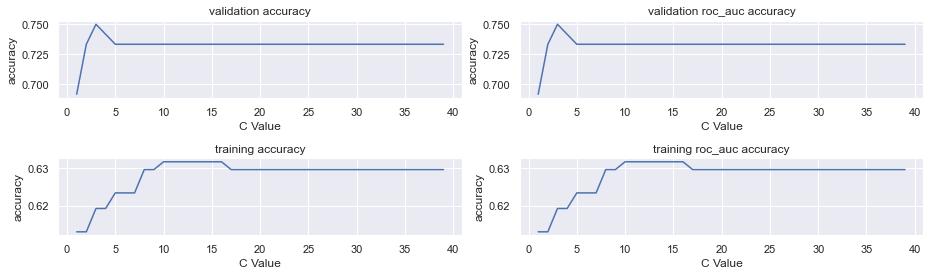

In [90]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    LR_balanced = LogisticRegression(C=i, random_state=42)
    LR_balanced.fit(X_train_balanced, y_train_balanced)
    
    val_predict = LR_balanced.predict(X_val_balanced)
    val_acc.append(accuracy_score(y_val_balanced, val_predict))
    val_auc.append(roc_auc_score(y_val_balanced, val_predict))
    
    train_predict = LR_balanced.predict(X_train_balanced)
    train_acc.append(accuracy_score(y_train_balanced, train_predict))
    train_auc.append(roc_auc_score(y_train_balanced, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

In [91]:
LR_balanced = LogisticRegression(C=5, random_state=42)
LR_balanced.fit(X_train_balanced, y_train_balanced)
val_prediction = LR_balanced.predict(X_val_balanced)
val_acc_scores["LR_balanced"] = accuracy_score(y_val_balanced, val_prediction)
val_auc_scores["LR_balanced"] = roc_auc_score(y_val_balanced, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["LR_balanced"], val_auc_scores["LR_balanced"]))

accuracy: 0.7333333333333333
roc_accuracy: 0.7333333333333334


## Specificity and sensitivity

We have seen that the performance varies with each model and with the different data sets. However, we value the roc_accuracy_score above the standard accuracy score. So lets take a look at how each of the models peform.

In [92]:
specificity = {}
sensitivity = {}

In [93]:
classifiers_1 = [KNN, DTC, RFC, SV, LR]
classifier_strings_1 = ["KNN", "DTC", "RFC", "SV", "LR"]         
classifiers_2 = [KNN_balanced, DTC_balanced, RFC_balanced,SV_balanced,LR_balanced]
classifier_strings_2 = ["KNN_balanced", "DTC_balanced", "RFC_balanced", "SV_balanced", "LR_balanced"]

for i in range(len(classifiers_1)):
    val_prediction = classifiers_1[i].predict(X_val)
    tn, fp, fn, tp = confusion_matrix(y_val, val_prediction).ravel()
    specificity[classifier_strings_1[i]] = tn / (tn+fp)
    sensitivity[classifier_strings_1[i]] = tp / (tp + fn)

for i in range(len(classifiers_2)):
    val_prediction = classifiers_2[i].predict(X_val_balanced)
    tn, fp, fn, tp = confusion_matrix(y_val_balanced, val_prediction).ravel()
    specificity[classifier_strings_2[i]] = tn / (tn+fp)
    sensitivity[classifier_strings_2[i]] = tp / (tp + fn)

In [94]:
specificity

{'KNN': 0.9227272727272727,
 'DTC': 0.8136363636363636,
 'RFC': 0.9363636363636364,
 'SV': 0.0,
 'LR': 0.95,
 'KNN_balanced': 0.5333333333333333,
 'DTC_balanced': 0.6833333333333333,
 'RFC_balanced': 0.75,
 'SV_balanced': 0.9833333333333333,
 'LR_balanced': 0.85}

In [95]:
sensitivity

{'KNN': 0.15,
 'DTC': 0.23333333333333334,
 'RFC': 0.11666666666666667,
 'SV': 1.0,
 'LR': 0.06666666666666667,
 'KNN_balanced': 0.7666666666666667,
 'DTC_balanced': 0.7166666666666667,
 'RFC_balanced': 0.7333333333333333,
 'SV_balanced': 0.4,
 'LR_balanced': 0.6166666666666667}

## Conclusion, what do we pick as our classifier?


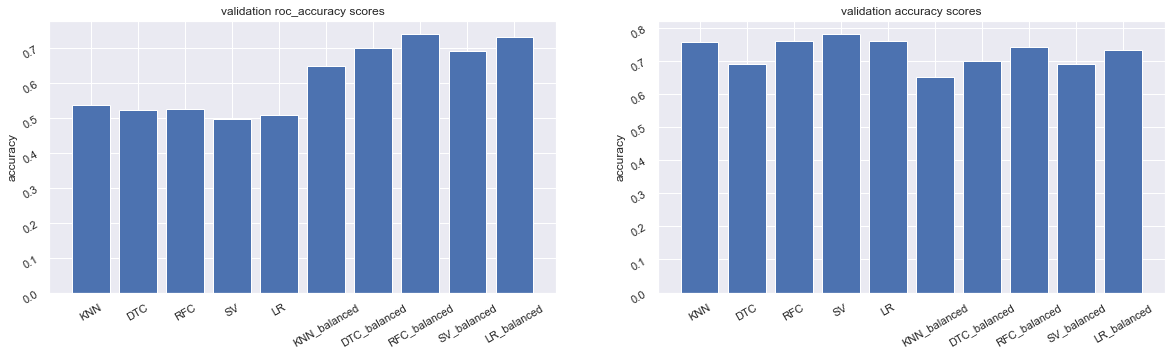

In [96]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].bar(val_auc_scores.keys(), val_auc_scores.values())
ax[1].bar(val_acc_scores.keys(), val_acc_scores.values())

ax[0].set_title("validation roc_accuracy scores")
ax[1].set_title("validation accuracy scores");
ax[1].set_ylabel("accuracy")
ax[0].set_ylabel("accuracy");
ax[0].tick_params(labelrotation=30)
ax[1].tick_params(labelrotation=30)

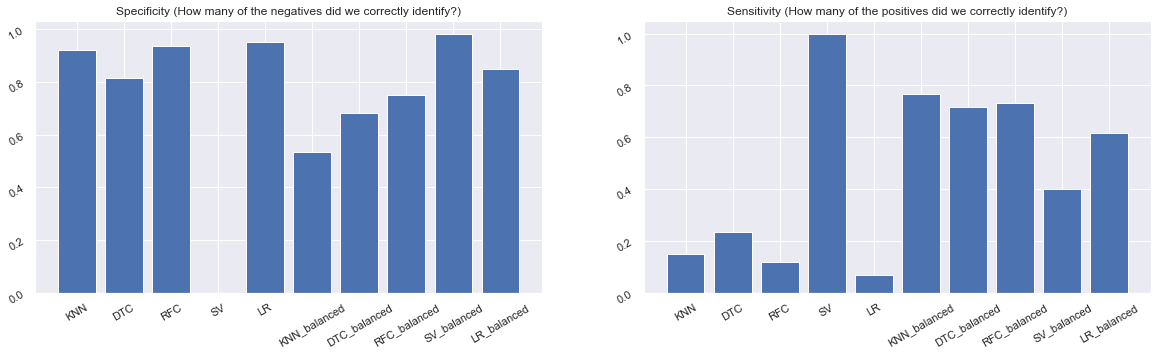

In [97]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].bar(specificity.keys(), specificity.values())
ax[1].bar(sensitivity.keys(), sensitivity.values())
ax[0].set_title("Specificity (How many of the negatives did we correctly identify?)")
ax[1].set_title("Sensitivity (How many of the positives did we correctly identify?)");
ax[1].tick_params(labelrotation=30)
ax[0].tick_params(labelrotation=30)

Here we see that our models can be really good at identifying non-cancerous lesions. It can also be decent at identifiying cancerous lesions. The problem is that none of the models are great at both.

We decide to go for Random Forest Classifier trained on balanced data, since it performed well in almost all cases, and we value sensitivity higher than a high specificity.

### Chosen model

In [98]:
model = RFC_balanced
df = pd.DataFrame(y_test_balanced)

In [99]:
X_predict = model.predict(X_test_balanced)
df["melanoma_predicted"] = X_predict

In [100]:
accuracy_score(df["melanoma"], df["melanoma_predicted"])

0.6066666666666667

In [101]:
roc_auc_score(df["melanoma"], df["melanoma_predicted"])

0.6066666666666667

In [102]:
mask_1 = (df["melanoma"] == 1) & (df["melanoma_predicted"] == 0)
mask_2 = (df["melanoma"] == 1) & (df["melanoma_predicted"] == 1)
mask_3 = (df["melanoma"] == 0) & (df["melanoma_predicted"] == 0)
mask_4 = (df["melanoma"] == 0) & (df["melanoma_predicted"] == 1)

In [103]:
print("Lesion was melanoma, and was predicted to be non-cancerous: {}".format(df[mask_1].shape[0]))
print("Lesion was melanoma, and was predicted to be melanoma: {}".format(df[mask_2].shape[0]))
print("Lesion was not melanoma, and was predicted to be non-cancerous: {}".format(df[mask_3].shape[0]))
print("Lesion was not melanoma, and was predicted to be melanoma: {}".format(df[mask_4].shape[0]))

Lesion was melanoma, and was predicted to be non-cancerous: 28
Lesion was melanoma, and was predicted to be melanoma: 47
Lesion was not melanoma, and was predicted to be non-cancerous: 44
Lesion was not melanoma, and was predicted to be melanoma: 31


In [104]:
tn, fp, fn, tp = confusion_matrix(df["melanoma"], df["melanoma_predicted"]).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)

print("Specificity: {}\nSensitivity: {}".format(specificity, sensitivity))

Specificity: 0.5866666666666667
Sensitivity: 0.6266666666666667


We can conclude that the symmetry feature in a picture, can be calculated easily without any measurable unit reference such as cm. Though border variations, area and perimeter can not reliably be calculated withut a reference measurement unit, since they are dependent on the resolution of the picture. The amount of pixels will vary on multiple factors such as, different quality of cameras, camera distance from the lesion when the picture was taken.

On the basis of the following Machine Learning analysis, we can also conclude that given our feature selection and the data. Visual extraction of features and classifying a lesion on the basis of these features is not accuracte/reliable enough to classify lesions

# Task 3: Open question

Research Question: What will keratosis be classified as using ML model trained on melanoma data?

We will use each feature to measure the images diagnosed with keratosis and run the model to see how it performs on other cancerous lesion types.

In [105]:
keratosis

,Unnamed: 0,Unnamed: 0.1,image_id,melanoma,seborrheic_keratosis,radius_sd,radius_mean,area,perimeter,compactness,...,g_range,b_range,r_pct,g_pct,b_pct,r_low,b_high,vertical_symmetry,horisontal_symmetry,symmetry
0,0,0,ISIC_0012090,0.0,1.0,566.451568,2026.929601,2301108.0,5410.0,1.012156,...,0.567839,0.639594,0.4064,0.3021,0.2915,0.0000,0.0140,0.858322,0.782705,0.820514
1,1,1,ISIC_0012103,0.0,1.0,262.772296,795.398072,439154.0,3062.0,1.698962,...,0.743719,0.766497,0.4925,0.2664,0.2411,0.0000,0.1155,0.915581,0.873456,0.894519
2,2,2,ISIC_0012117,0.0,1.0,409.687756,843.173136,1550129.0,6124.0,1.925275,...,0.618090,0.730964,0.4262,0.3128,0.2610,0.0000,0.0333,0.898514,0.916337,0.907425
3,3,3,ISIC_0012155,0.0,1.0,183.872935,526.098666,232443.0,1664.0,0.947939,...,0.160804,0.157360,0.4814,0.2724,0.2462,0.0000,0.0000,0.955863,0.972294,0.964079
4,4,4,ISIC_0012170,0.0,1.0,511.329663,1122.722029,1865538.0,4453.0,0.845846,...,0.603015,0.670051,0.4068,0.2969,0.2964,0.0000,0.3933,0.777293,0.879578,0.828435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,249,249,ISIC_0015182,0.0,1.0,705.297587,1783.085685,8032131.0,13235.0,1.735431,...,1.000000,1.000000,0.3654,0.3105,0.3241,0.2044,0.1129,0.848664,0.833769,0.841216
250,250,250,ISIC_0015220,0.0,1.0,1456.570181,2901.239656,21601460.0,19049.0,1.336754,...,1.000000,1.000000,0.4956,0.2572,0.2472,0.0000,0.0559,0.814070,0.850882,0.832476
251,251,251,ISIC_0015233,0.0,1.0,1087.334537,2185.439481,7283040.0,9163.0,0.917387,...,1.000000,1.000000,0.4332,0.3111,0.2558,0.0417,0.0409,0.887713,0.771742,0.829727
252,252,252,ISIC_0015260,0.0,1.0,971.563498,2091.322301,5988825.0,12321.0,2.017160,...,0.979899,1.000000,0.4062,0.3208,0.2730,0.1064,0.0448,0.539334,0.551170,0.545252


In [106]:
df = keratosis

In [107]:
X = df.drop(["Unnamed: 0", "Unnamed: 0.1","image_id", "melanoma", "seborrheic_keratosis", "diagnosis_sum", "diagnosis"], axis = 1)
Y = df["seborrheic_keratosis"]

We reuse the chosen ML model from Task 2, i.e the Random Forest Classifier trained on the balanced data. We then also find the features it was trained on and predict using those same features with the keratosis dataset

In [108]:
classifier = RFC_balanced

We use the classifier to predict

In [109]:
X = X[["radius_sd","vertical_symmetry", "relative_color_variance"]]
X_predict = classifier.predict(X)
df["keratosis_predicted"] = X_predict

We find the number of False Positives, False Negatives, True Positives, True Negatives. There will be no False Negative, True Negative since we are only predicting on a dataset containing keratosis cases.

In [110]:
mask_1 = (df["seborrheic_keratosis"] == 1) & (df["keratosis_predicted"] == 0)
mask_2 = (df["seborrheic_keratosis"] == 1) & (df["keratosis_predicted"] == 1)
mask_3 = (df["seborrheic_keratosis"] == 0) & (df["keratosis_predicted"] == 0)
mask_4 = (df["seborrheic_keratosis"] == 0) & (df["keratosis_predicted"] == 1)

In [111]:
print("Lesion was seborrheic keratosis, and was predicted to be non-cancerous: {}".format(df[mask_1].shape[0]))
print("Lesion was seborrheic keratosis, and was predicted to be cancerous: {}".format(df[mask_2].shape[0]))
print("Lesion was non-cancerous, and was predicted to be non-cancerous: {}".format(df[mask_3].shape[0]))
print("Lesion was non-cancerous, and was predicted to be cancerous: {}".format(df[mask_4].shape[0]))

Lesion was seborrheic keratosis, and was predicted to be non-cancerous: 96
Lesion was seborrheic keratosis, and was predicted to be cancerous: 158
Lesion was non-cancerous, and was predicted to be non-cancerous: 0
Lesion was non-cancerous, and was predicted to be cancerous: 0


So here we see, that if a model has only trained on a balanced amount of melanoma and non-melanoma, then it will falsely classify 60% of seborrheic keratosis as cancerous, when they infact are non-cancerous.

Thus this could mean, that if a new skin lesion type emerged (in this case benign) and one would use existing ML models to predict whether it was cancer or not. Four scenarios will/could emerge:

- Cancerous lesion classified as non-cancerous, would not be treated and the cancer in the subject would increase and thus potentially killing people. 

- Benign lesion classified as cancerous, then the subject will be treated as if it was cancer, i.e go through chemotherapy unnecessarily 

- Cancerous lesion classified as cancerous, subject gets the correct treatment.

- Benign lesion classified as non-cancerous, subject gets the correct treatment.